# Objective of the project: Understand and build models to predict the stock price
### Data: 
    1. The stock prices of Google, Apple, Meta, Netflix, Amazon, Ebay are considered for this analysis.
    2. Train data is from the time period between the December 14th and March 13th. 
    3. Data been directly downloaded from the yfinance library
  
### Methodologies:
    To predict the closing price at 15 Minute intervals with the previous 15 Minute intervals and other features
    1. Data Wrangling
    2. Feature Engineering
    3. Linear Regression (L1 & L2 Norms as well)
    4. Decision trees (CART algorithms, Random Forest, XGB, CAT boost)
    5. Neural Networks (LSTM - RNN)

### Structure of Notebook:
    1. Data Download
    2. Exploratory Data Analysis & Feature engineering
    3. Model Development & Validation
    4. Model Selection & Testing

### 1. Data Download Method

In [2]:
import yfinance as yf
import pandas as pd
#from google.colab import drive
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LassoCV,Lasso
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.decomposition import PCA
import math
import statistics
import xgboost as xgb
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM
#drive.mount("/content/gdrive/")

In [3]:
def download_data(stocks_ticker_list,time_period,time_interval):
  
  df_data_final = pd.DataFrame()
  
  for stock in stocks_ticker_list:
    df_data = yf.download(tickers = stock,period = time_period, interval = time_interval, auto_adjust = True,prepost = False,threads = True,proxy = None)
    df_data['stock'] = stock
    df_data_final = pd.concat([df_data,df_data_final])
  return df_data_final

In [ ]:
# df_data = download_data(["AAPL","META","NFLX","AMZN","EBAY","GOOGL"],time_period="60d",time_interval="15m")
# file_path='/content/gdrive/Shared drives/ML & DDR Project/ML Project/Data/stock_data.csv'
# with open(file_path, 'w') as f:
#   df_data.to_csv(file_path)

#### Data Loading

In [6]:
# file_path='/content/gdrive/Shared drives/ML & DDR Project/ML Project/Data/stock_data.csv'
# with open(file_path,'r') as data:
#   df_data = pd.read_csv(file_path)
with open('stock_data.csv','r') as data:
    df_data = pd.read_csv(data)

In [9]:
df_data['Datetime'] =  pd.to_datetime(df_data['Datetime'])
df_data.head(2)

,Datetime,Open,High,Low,Close,Volume,stock
0,2022-12-14 09:30:00,95.199997,96.434998,95.18,96.010002,1921870,GOOGL
1,2022-12-14 09:45:00,95.980003,96.080002,95.50,95.820000,991742,GOOGL


### Exploratory Data Analysis

In [ ]:
df_data.groupby(['stock'])[[ 'Close']].agg(['mean', 'std', 'var'])

Close                       
             mean        std         var
stock                                   
AAPL   142.100416   9.379984   87.984108
AMZN    93.725308   6.432934   41.382638
EBAY    45.554932   3.153405    9.943965
GOOGL   93.167677   4.828585   23.315235
META   152.563766  26.258121  689.488944
NFLX   326.777066  27.229370  741.438610

In [ ]:
## Coefficient of Variation
df_data.groupby(['stock'])['Close'].apply(lambda x: np.std(x)/np.mean(x)).reset_index(name='Coefficient of Variation')

,stock,Coefficient of Variation
0,AAPL,0.065988
1,AMZN,0.068614
2,EBAY,0.069200
3,GOOGL,0.051810
4,META,0.172057
5,NFLX,0.083300


##### Insight-1: Except the Meta and NFLX has variation different to others, It might be due to the recent voltality of those stocks

##### Action-1: These voltalities, and price shocks across stocks can be induced into the model as well, in a hope that model would learn how to deal with those shocks even if it didn't happen to other stocks

#### Scatterplot for Closing prices and their lag terms

AAPL


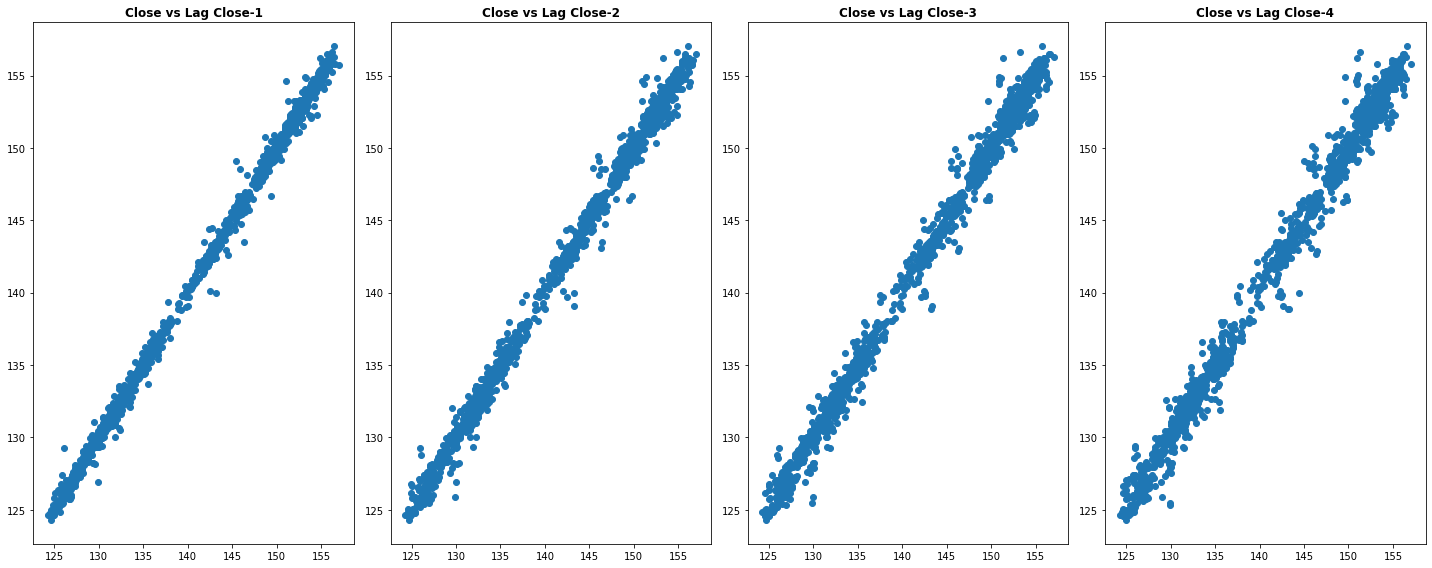

<Figure size 720x432 with 0 Axes>

META


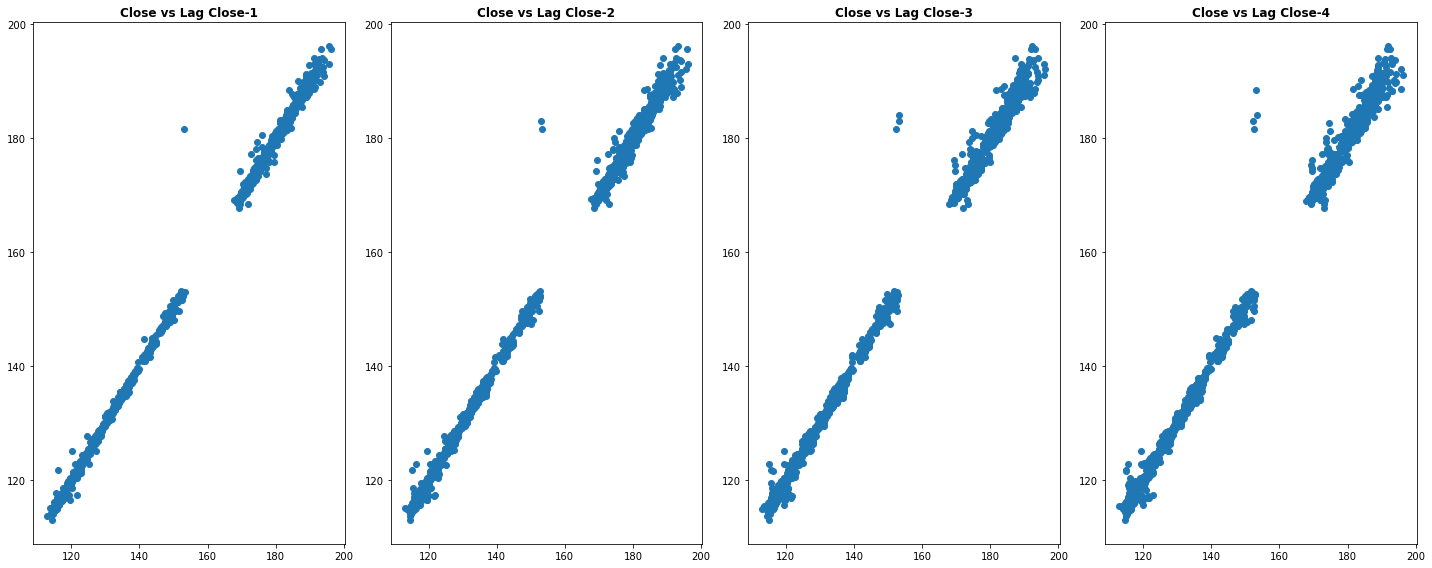

<Figure size 720x432 with 0 Axes>

NFLX


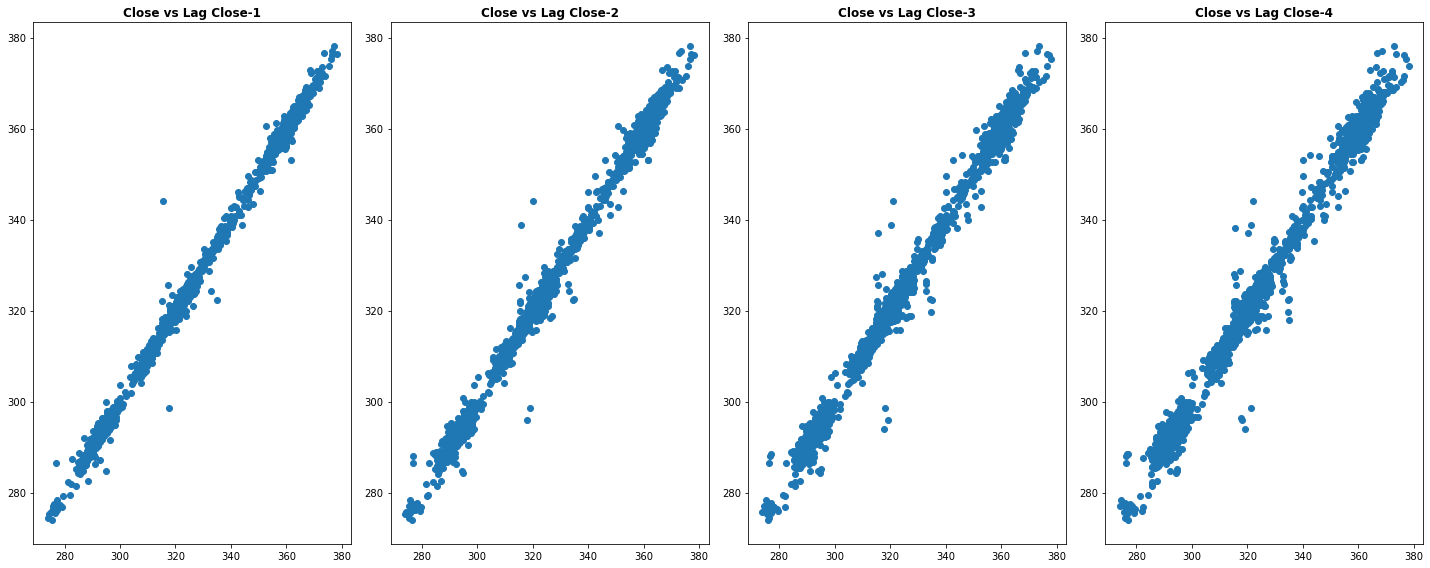

<Figure size 720x432 with 0 Axes>

AMZN


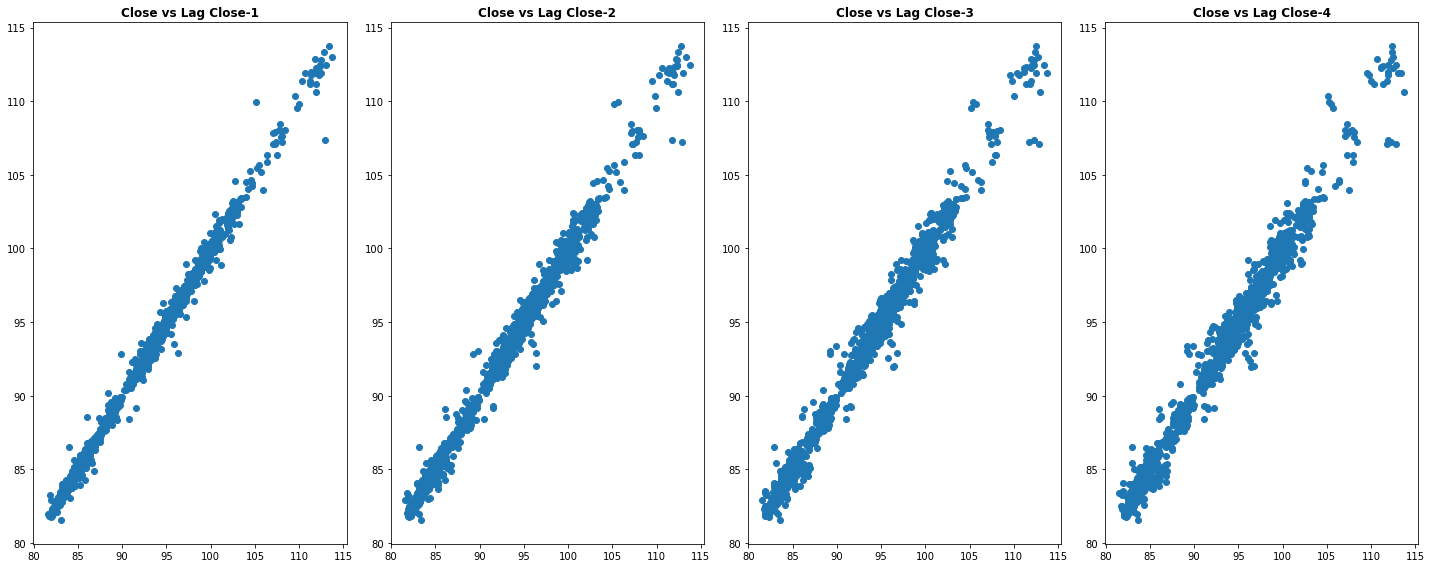

<Figure size 720x432 with 0 Axes>

EBAY


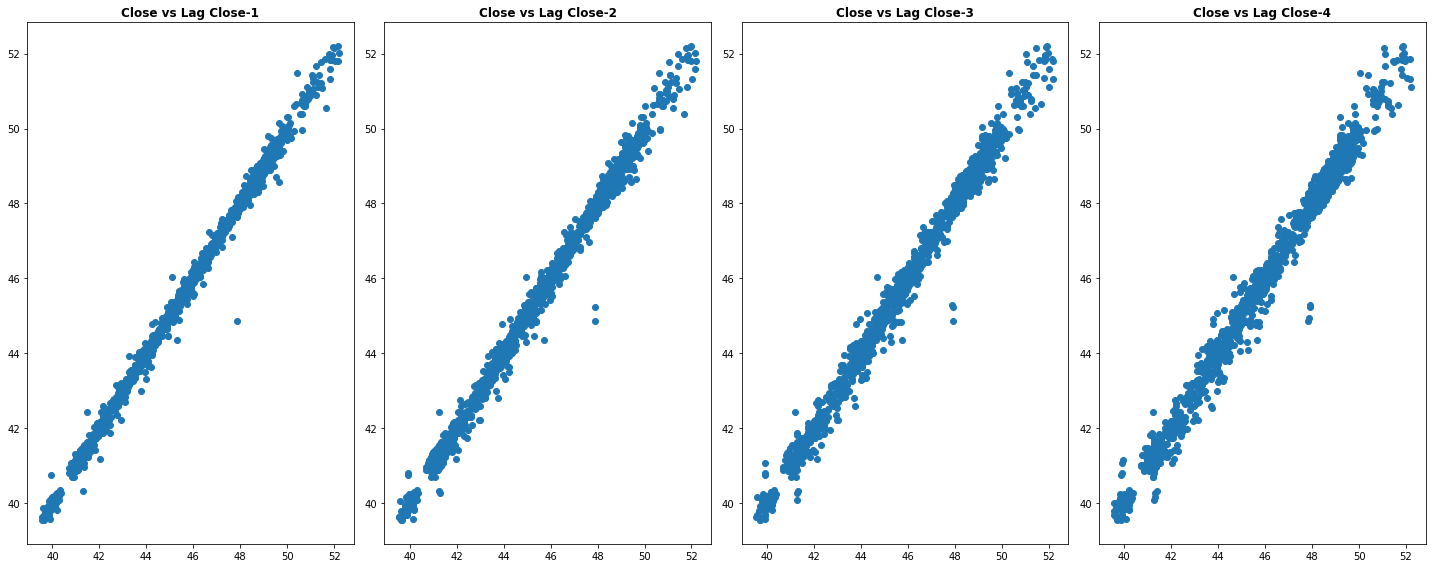

<Figure size 720x432 with 0 Axes>

GOOGL


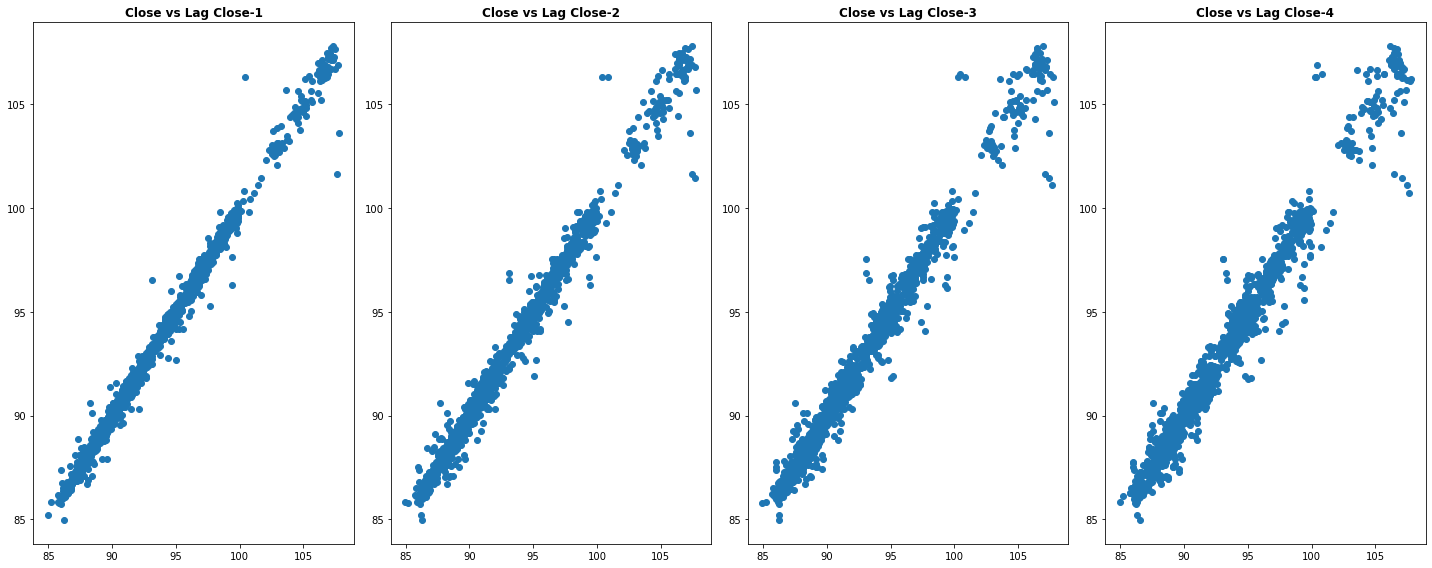

<Figure size 720x432 with 0 Axes>

In [ ]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    df_line =  df_data[df_data['stock']==i]
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,8))
    plt.figure(figsize=(10,6))
    ax1.scatter(df_line['Close'].shift(1),df_line['Close'])
    ax1.set_title('Close vs Lag Close-1', fontweight ="bold")
    ax2.scatter(df_line['Close'].shift(2),df_line['Close'])
    ax2.set_title('Close vs Lag Close-2', fontweight ="bold")
    ax3.scatter(df_line['Close'].shift(3),df_line['Close'])
    ax3.set_title('Close vs Lag Close-3', fontweight ="bold")
    ax4.scatter(df_line['Close'].shift(4),df_line['Close'])
    ax4.set_title('Close vs Lag Close-4', fontweight ="bold")
    print(i)
    fig.tight_layout()
    plt.show()

##### Insight-2: We can clearly see a linear correlation with respective to the Closing price and their lag terms

AAPL


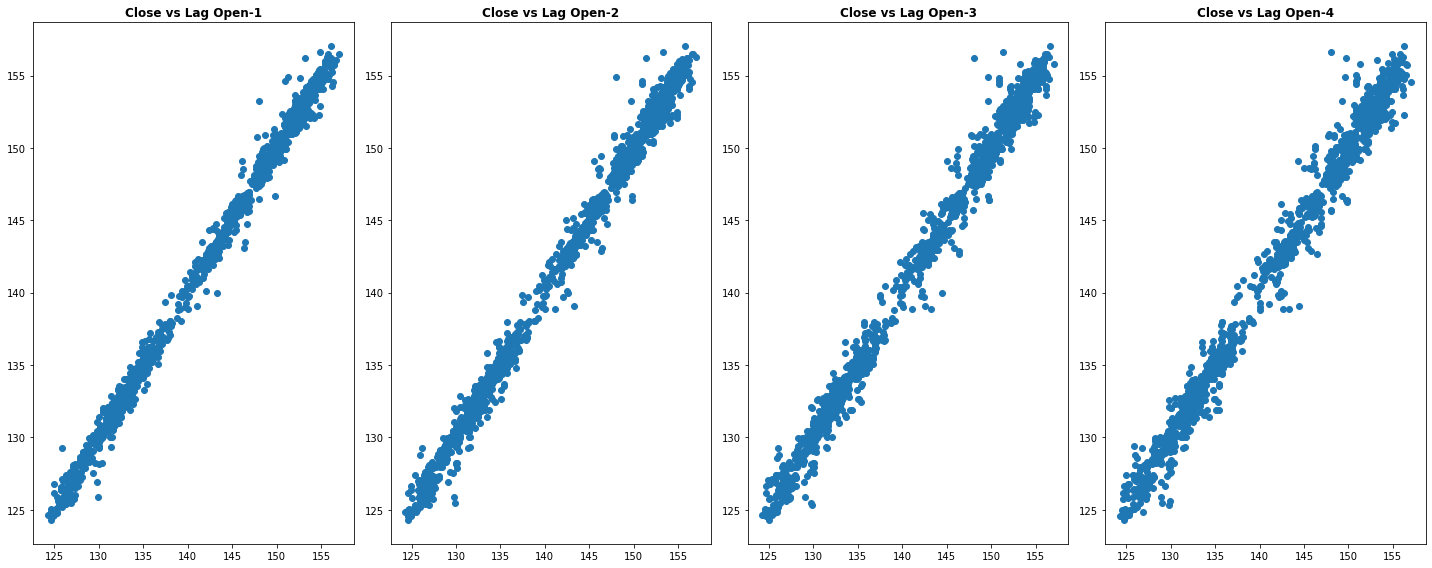

<Figure size 720x432 with 0 Axes>

META


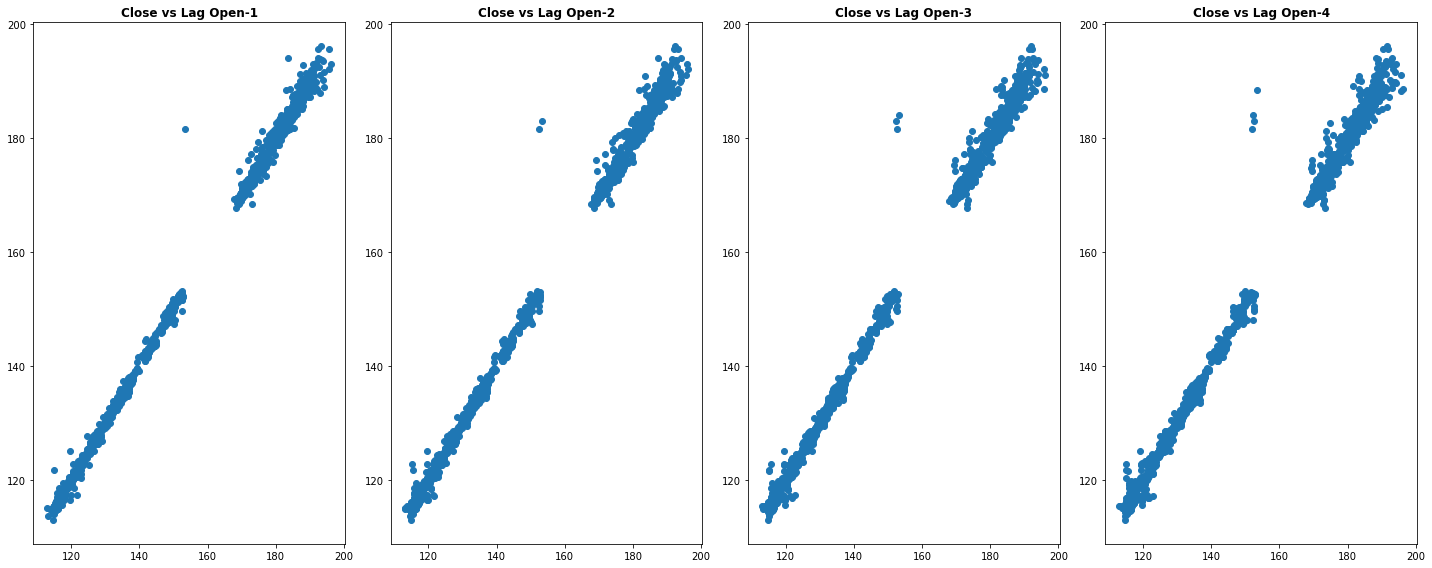

<Figure size 720x432 with 0 Axes>

NFLX


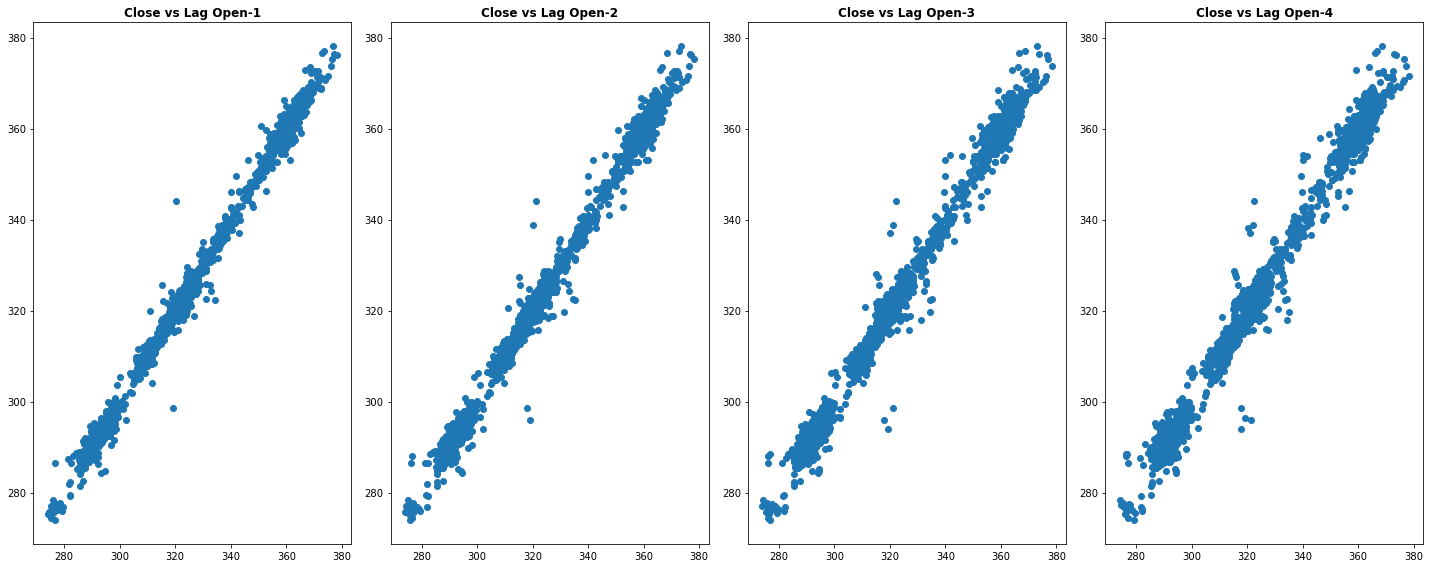

<Figure size 720x432 with 0 Axes>

AMZN


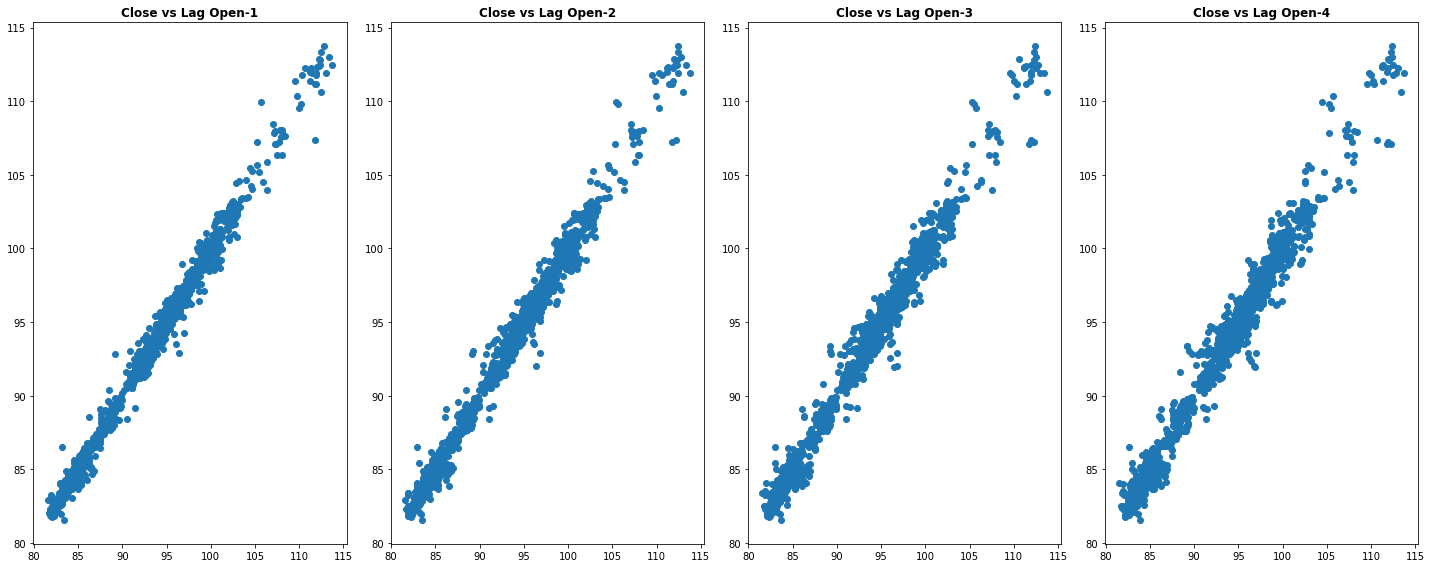

<Figure size 720x432 with 0 Axes>

EBAY


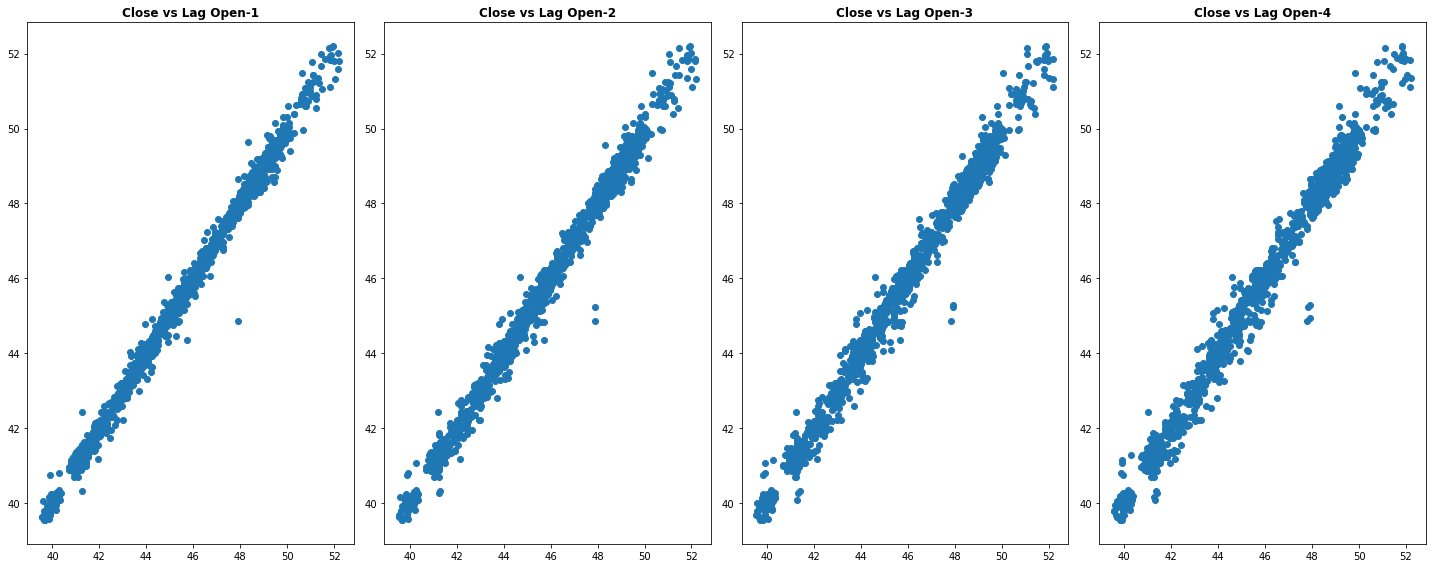

<Figure size 720x432 with 0 Axes>

GOOGL


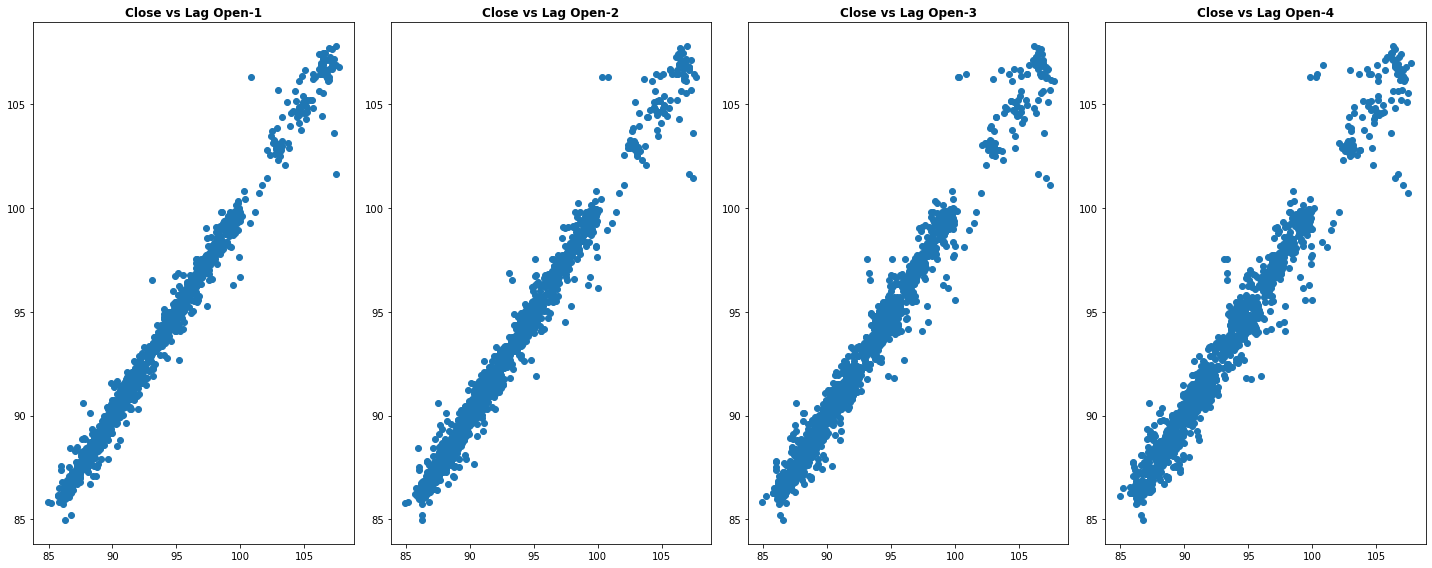

<Figure size 720x432 with 0 Axes>

In [ ]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    df_line =  df_data[df_data['stock']==i]
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,8))
    plt.figure(figsize=(10,6))
    ax1.scatter(df_line['Open'].shift(1),df_line['Close'])
    ax1.set_title('Close vs Lag Open-1', fontweight ="bold")
    ax2.scatter(df_line['Open'].shift(2),df_line['Close'])
    ax2.set_title('Close vs Lag Open-2', fontweight ="bold")
    ax3.scatter(df_line['Open'].shift(3),df_line['Close'])
    ax3.set_title('Close vs Lag Open-3', fontweight ="bold")
    ax4.scatter(df_line['Open'].shift(4),df_line['Close'])
    ax4.set_title('Close vs Lag Open-4', fontweight ="bold")
    print(i)
    fig.tight_layout()
    plt.show()

In [ ]:
# ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]
# fig, (ax1, ax2,ax3,ax4,ax6) = plt.subplots(1,5, figsize=(20,8))
# plt.figure(figsize=(10,6))
# ax1.scatter(df_data[df_data['stock']=='AAPL']['Close'],df_line['Volume'].shift(1))
# ax1.set_title('Close vs Lag Volume - AAPL', fontweight ="bold")
# ax2.scatter(df_data[df_data['stock']=='META']['Close'],df_line['Volume'].shift(1))
# ax2.set_title('Close vs Lag Volume - META', fontweight ="bold")
# ax3.scatter(df_data[df_data['stock']=='NFLX']['Close'],df_line['Volume'].shift(1))
# ax3.set_title('Close vs Lag Volume-NFLX', fontweight ="bold")
# ax4.scatter(df_data[df_data['stock']=='AMZN']['Close'],df_line['Volume'].shift(1))
# ax4.set_title('Close vs Lag Volume-AMZN', fontweight ="bold")
# # ax5.scatter(df_data[df_data['stock']=='GOOG']['Close'],df_line['Volume'].shift(1))
# # ax5.set_title('Close vs Lag Volume-GOOGL', fontweight ="bold")
# ax6.scatter(df_data[df_data['stock']=='EBAY']['Close'],df_line['Volume'].shift(1))
# ax6.set_title('Close vs Lag Volume-EBAY', fontweight ="bold")
# fig.tight_layout()
# plt.show()

AAPL


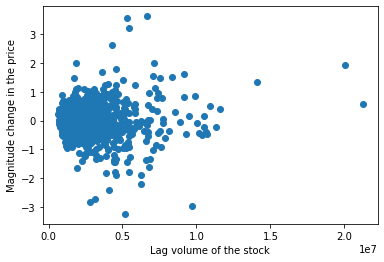

META


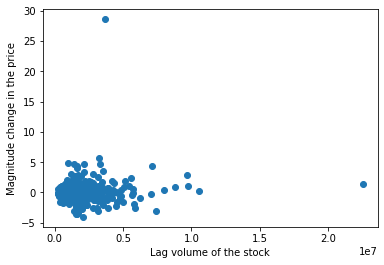

NFLX


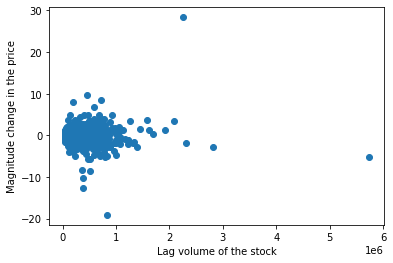

AMZN


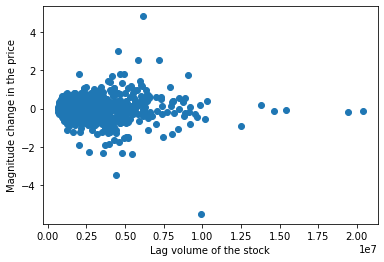

EBAY


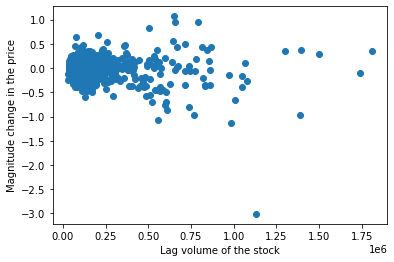

GOOGL


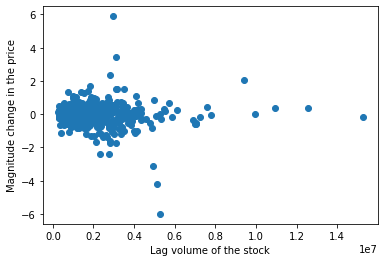

In [ ]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    df_line =  df_data[df_data['stock']==i]
    plt.scatter(df_line['Volume'].shift(1),df_line['Close']-df_line['Close'].shift(1))
    plt.xlabel("Lag volume of the stock")
    plt.ylabel("Magnitude change in the price")
    print(i)
    plt.show()

##### Insight-3: There is slight correlation between both the Volume and Magnitude difference

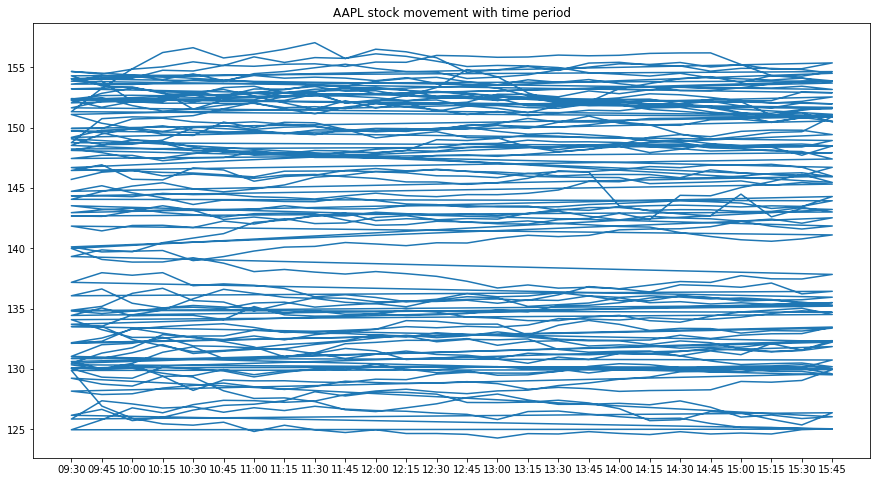

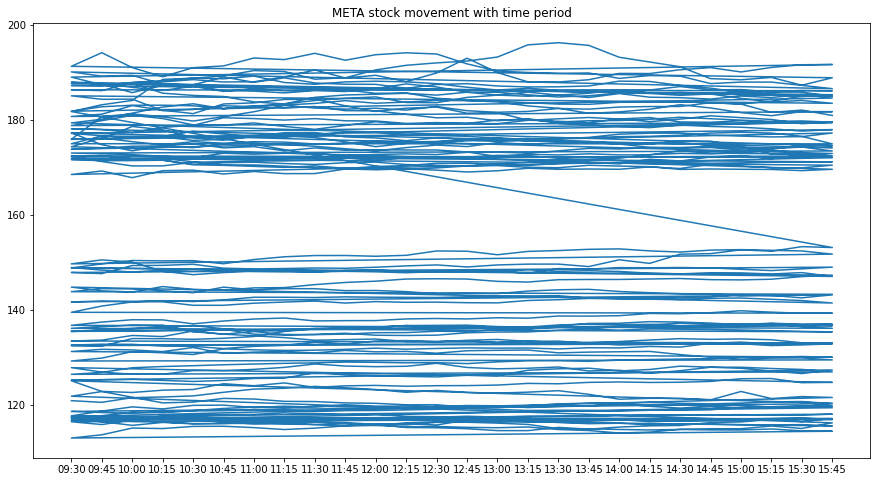

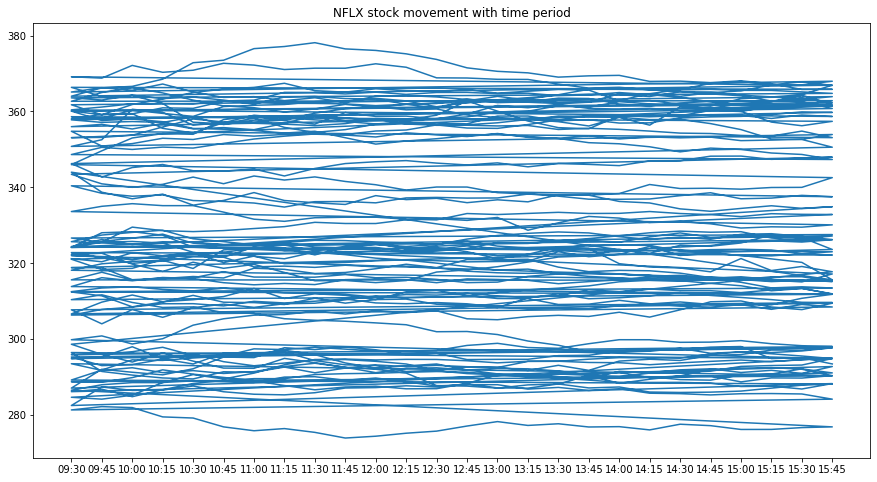

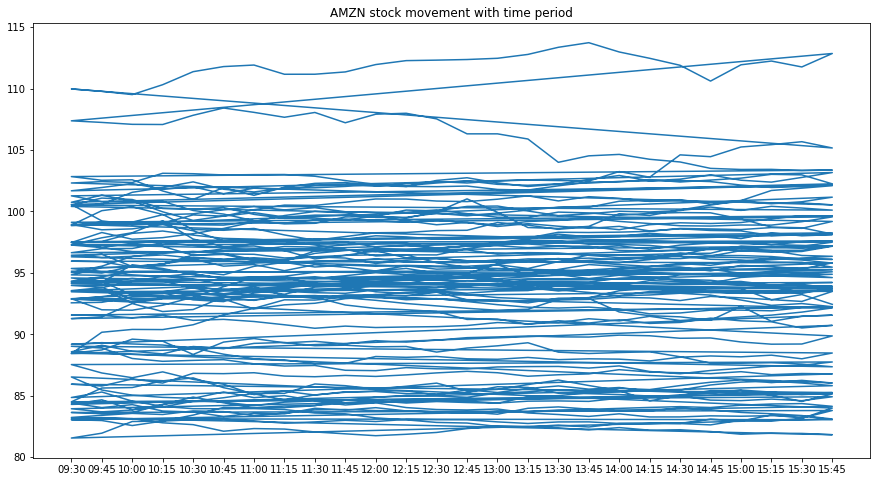

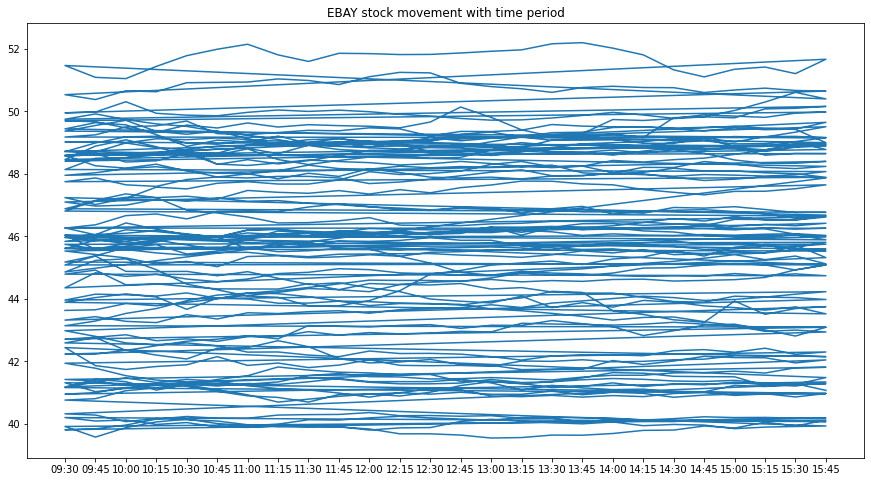

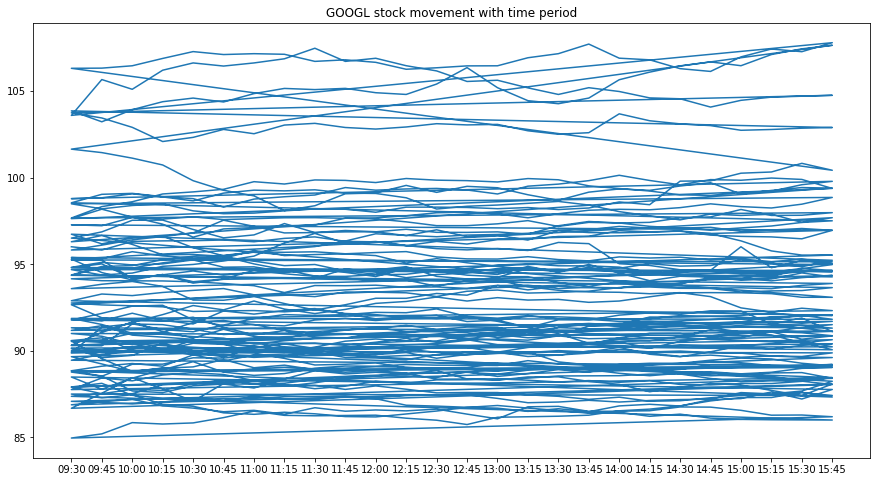

In [ ]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    plt.figure(figsize=(15,8))
    plt.plot(df_data[df_data['stock']==i]['Datetime'].dt.strftime('%H:%M'), df_data[df_data['stock']==i]['Close'])
    plt.title("{} stock movement with time period".format(i))
    plt.show()

##### Insight-4: The movement of the stock slightly depends upon the timeperiod

In [19]:
def lagged_columns(df, groupby_column, columns_to_lag, num_lags):
    df_new = df.copy()
    for i in range(1, num_lags + 1):
        for col in columns_to_lag:
            lag_col_name = f"{col}_lag{i}"
            df_new[lag_col_name] = df_new.groupby(groupby_column)[col].shift(i)
    return df_new

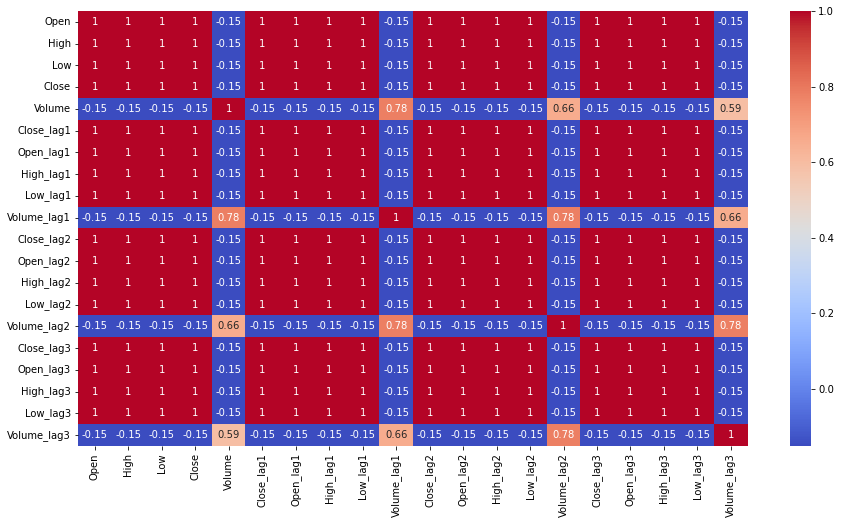

In [ ]:
df_eda = lagged_columns(df_data, 'stock', ['Close','Open','High','Low','Volume'],3)
corr_matrix=df_eda.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

##### Insight:5 - There is high correlation between the last 3 lags and the closing prices.Moreover lags are also highly correlated to the other lag

##### Action-2: We may need to apply Lasso CV to validate our findings about the correlations 

### Daily Data Loading 

In [ ]:
#df_data_daily = download_data(["AAPL","META","NFLX","AMZN","EBAY","GOOGL"],time_period="70d",time_interval="1d")
# file_path='/content/gdrive/Shared drives/ML & DDR Project/ML Project/Data/stock_data_daily.csv'
# with open(file_path,'r') as data:
#   df_data_daily = pd.read_csv(file_path)
with open('stock_data_daily.csv','r') as data:
    df_data_daily = pd.read_csv(data)

In [ ]:
df_data_daily.rename(columns={'Open':'daily_open','High':'daily_high','Low':'daily_low','Close':'daily_close','Volume':'daily_volume'},inplace=True)

In [ ]:
df_data_daily['Date'] =  pd.to_datetime(df_data_daily['Date'])
df_data_daily['Date'] = df_data_daily['Date'] + pd.Timedelta(days=1)
df_data['Datetime'] =  pd.to_datetime(df_data['Datetime'])
df_data['Date']=df_data['Datetime'].dt.date
df_data['Date'] =  pd.to_datetime(df_data['Date'])

In [ ]:
df_data.head(1)

,Date,Open,High,Low,Close,Volume,stock
0,2022-12-07,96.410004,96.879997,94.720001,94.940002,31045400,GOOGL


### Merge 15Minute interval with previous date data

In [ ]:
df_eda=pd.merge(df_data,df_data_daily,on=['Date', 'stock'])

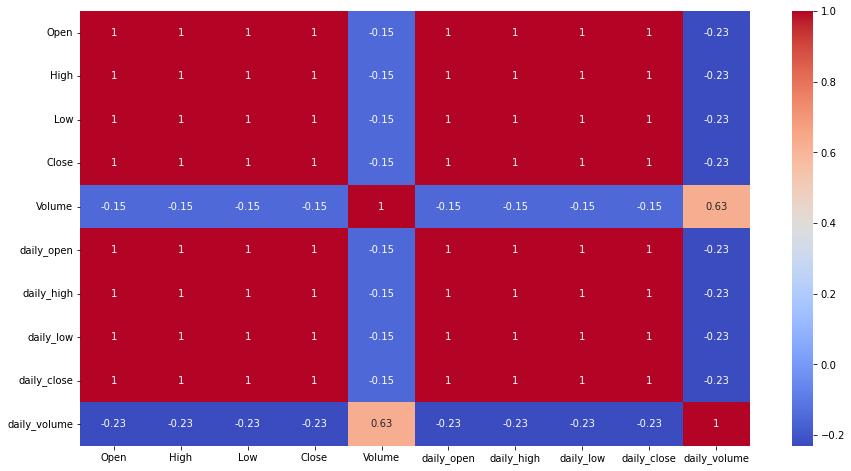

In [ ]:
corr_matrix=df_eda.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Principal Component Analysis

In [20]:
df_data_pca =  lagged_columns(df_data, 'stock', ['Close','Open','High','Low','Volume'],3)

In [ ]:
df_data_pca.dropna(inplace=True)

In [ ]:
df_data_pca['time_period']=df_data_pca['Datetime'].dt.strftime('%H%M')
df_data_pca.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'stock', 'Date',
       'Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
       'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
       'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
       'time_period'],
      dtype='object')

In [ ]:
x_columns=['Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
       'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
       'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
       'time_period']

In [ ]:
len(principal_components[:, 0])

1557

In [ ]:
df_data_pca['Datetime'].shape

(9342,)

In [ ]:
pca1_top_loadings[:5]

array([ 4,  9, 14, 15,  2], dtype=int64)

[0.75141691 0.1588432  0.03709637 0.03338715 0.01828526]
Top 5 loadings for PCA1: ['Volume_lag1' 'Volume_lag2' 'Volume_lag3' 'time_period' 'High_lag1']
Top 5 loadings for PCA2: ['Volume_lag2' 'Volume_lag1' 'Volume_lag3' 'High_lag1' 'High_lag2']


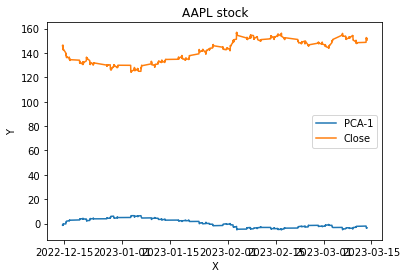

[0.75674537 0.15256621 0.04610982 0.02788492 0.01628277]
Top 5 loadings for PCA1: ['High_lag1' 'High_lag2' 'Open_lag1' 'Close_lag1' 'Close_lag2']
Top 5 loadings for PCA2: ['Volume_lag2' 'Volume_lag1' 'Volume_lag3' 'High_lag1' 'Close_lag1']


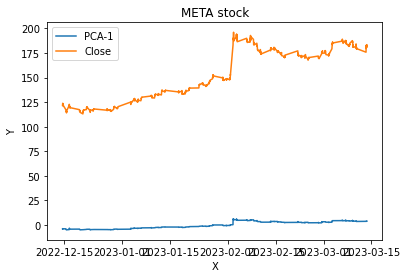

[0.74868692 0.1588569  0.04378436 0.03194595 0.01550525]
Top 5 loadings for PCA1: ['Volume_lag1' 'Volume_lag2' 'Volume_lag3' 'time_period' 'Close_lag1']
Top 5 loadings for PCA2: ['Volume_lag2' 'Volume_lag1' 'Volume_lag3' 'High_lag1' 'High_lag2']


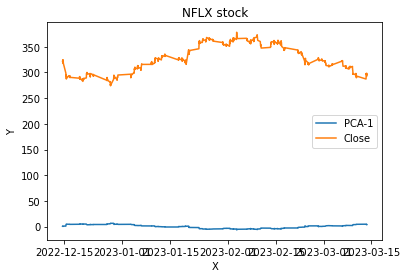

[0.75257092 0.15949668 0.03673695 0.03297864 0.01633754]
Top 5 loadings for PCA1: ['High_lag2' 'Close_lag2' 'Open_lag2' 'High_lag1' 'Close_lag3']
Top 5 loadings for PCA2: ['Volume_lag2' 'Volume_lag1' 'Volume_lag3' 'High_lag1' 'High_lag2']


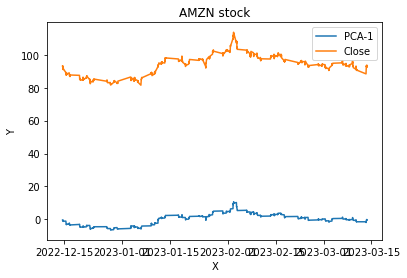

[0.7491209  0.13113902 0.04882282 0.04118642 0.02861953]
Top 5 loadings for PCA1: ['Low_lag2' 'Close_lag2' 'Open_lag2' 'High_lag2' 'Open_lag1']
Top 5 loadings for PCA2: ['Volume_lag2' 'Volume_lag3' 'Volume_lag1' 'High_lag3' 'High_lag2']


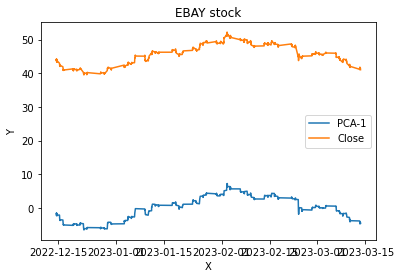

[0.76401746 0.14618557 0.04103702 0.03156316 0.0144186 ]
Top 5 loadings for PCA1: ['High_lag2' 'High_lag3' 'Open_lag2' 'Close_lag2' 'Close_lag3']
Top 5 loadings for PCA2: ['Volume_lag2' 'Volume_lag1' 'Volume_lag3' 'High_lag3' 'High_lag2']


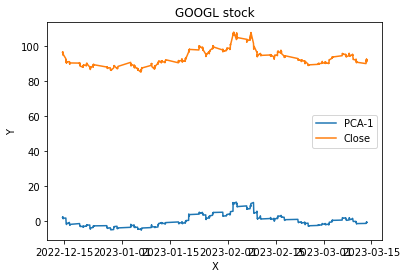

In [ ]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(df_data_pca[df_data_pca['stock']==i][x_columns])
    
    pca = PCA(n_components=5)
    principal_components = pca.fit_transform(x_scaled)
    explained_variances = pca.explained_variance_ratio_
    print(explained_variances)
    loadings = pca.components_
    pca1_loadings = loadings[0,:]
    pca2_loadings = loadings[1,:]

    pca1_top_loadings = np.argsort(pca1_loadings)[::-1]
    pca2_top_loadings = np.argsort(pca2_loadings)[::-1]

    x_columns_array = np.array(x_columns)

    print(f"Top 5 loadings for PCA1: {x_columns_array[pca1_top_loadings[:5]]}")
    print(f"Top 5 loadings for PCA2: {x_columns_array[pca2_top_loadings[:5]]}")
    
    fig, ax = plt.subplots()
    ax.plot(df_data_pca[df_data_pca['stock']==i]['Datetime'],principal_components[:, 0], label='PCA-1')
    ax.plot(df_data_pca[df_data_pca['stock']==i]['Datetime'],df_data_pca[df_data_pca['stock']==i]['Close'], label='Close')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    ax.set_title("{} stock".format(i))
    plt.show()


##### Insight 6: For the Google, EBAY, Amazon, Meta was completely able to capture the trend of the stock prices

##### Insight 7: Almost 91% of the variance is explained by the first two Principal Components, suggesting the multicollinearity between the variables

##### Insight 8: Volume of the amounts traded is playing a role

### Data Preparation for Modelling

In [27]:
### Take the last 3 intervals
df_model_data =  lagged_columns(df_data, 'stock', ['Close','Open','High','Low','Volume'],3)

In [32]:
### Add the Before Day Interval
# file_path='/content/gdrive/Shared drives/ML & DDR Project/ML Project/Data/stock_data_daily.csv'
# with open(file_path,'r') as data:
#   df_data_daily = pd.read_csv(file_path)
with open('stock_data_daily.csv','r') as data:
    df_data_daily = pd.read_csv(data)
df_data_daily.rename(columns={'Open':'daily_open','High':'daily_high','Low':'daily_low','Close':'daily_close','Volume':'daily_volume'},inplace=True)
df_data_daily['Date'] =  pd.to_datetime(df_data_daily['Date'])
df_data_daily['Date'] = df_data_daily['Date'] + pd.Timedelta(days=1)
df_model_data['Date'] =  df_model_data['Datetime'].dt.date
df_model_data['Date'] =  pd.to_datetime(df_model_data['Date'])
df_model_data=df_model_data.merge(df_data_daily,on=['Date', 'stock'])

In [34]:
df_model_data['time_period']=df_model_data['Datetime'].dt.strftime('%H%M')
df_model_data.head(3)

,Datetime,Open,High,Low,Close,Volume,stock,Close_lag1,Open_lag1,High_lag1,...,High_lag3,Low_lag3,Volume_lag3,Date,daily_open,daily_high,daily_low,daily_close,daily_volume,time_period
0,2022-12-14 09:30:00,95.199997,96.434998,95.180000,96.010002,1921870,GOOGL,NaN,NaN,NaN,...,NaN,NaN,NaN,2022-12-14,97.760002,99.529999,95.029999,95.629997,40593700,0930
1,2022-12-14 09:45:00,95.980003,96.080002,95.500000,95.820000,991742,GOOGL,96.010002,95.199997,96.434998,...,NaN,NaN,NaN,2022-12-14,97.760002,99.529999,95.029999,95.629997,40593700,0945
2,2022-12-14 10:00:00,95.809998,96.504997,95.629997,96.320000,886065,GOOGL,95.820000,95.980003,96.080002,...,NaN,NaN,NaN,2022-12-14,97.760002,99.529999,95.029999,95.629997,40593700,1000


In [ ]:
stock_column = df_model_data['stock'].values.reshape(-1, 1)
stock_encoder = OneHotEncoder()
stock_encoder.fit(stock_column)
encoded_stock = stock_encoder.transform(stock_column).toarray()
feature_names = stock_encoder.get_feature_names(['stock'])
df_model_data_dum = pd.concat([df_model_data.drop(['stock'], axis=1), pd.DataFrame(encoded_stock,columns=feature_names)], axis=1)

C:\Users\vamsi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_model_data_dum.head(1)

,Datetime,Open,High,Low,Close,Volume,Date,Close_lag1,Open_lag1,High_lag1,...,daily_low,daily_close,daily_volume,time_period,stock_AAPL,stock_AMZN,stock_EBAY,stock_GOOGL,stock_META,stock_NFLX
0,2022-12-14 09:30:00,95.199997,96.434998,95.18,96.010002,1921870,2022-12-14,NaN,NaN,NaN,...,95.029999,95.629997,40593700,0930,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_model_data_dum['time_period'] = pd.to_numeric(df_model_data_dum['time_period'])

##### Note 1: The time period has been turned to numeric although its kind of categorical to save degrees of freedom 

In [ ]:
df_model_data.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'stock', 'Date',
       'Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
       'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
       'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
       'daily_open', 'daily_high', 'daily_low', 'daily_close', 'daily_volume',
       'time_period'],
      dtype='object')

### Error Target:

In [ ]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    mean_diff = np.mean((df_model_data[df_model_data['stock']==i]['Close']-df_model_data[df_model_data['stock']==i]['Close_lag1'])**2)
    print("The average mean difference between two interval for the {} stock is {}".format(i,mean_diff))

The average mean difference between two interval for the AAPL stock is 0.23160302546580858
The average mean difference between two interval for the META stock is 1.2121750066486086
The average mean difference between two interval for the NFLX stock is 2.9341371659003355
The average mean difference between two interval for the AMZN stock is 0.225081772873524
The average mean difference between two interval for the EBAY stock is 0.035482736865896536
The average mean difference between two interval for the GOOGL stock is 0.20633509923035795


#### Above value would be ideally the difference between two intervals, our MSE should be less than that to make profitables tradings and also less than the standard deviation

#### We are using Mean Squared Error for the Model Performance Evaluation

### Linear Regression

In [ ]:
x_columns=[ 'Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
       'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
       'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
       'daily_open', 'daily_high', 'daily_low', 'daily_close', 'daily_volume',
       'time_period','stock_AAPL', 'stock_AMZN', 'stock_GOOGL',
       'stock_META', 'stock_NFLX']
y_columns=['Close']

In [ ]:
df_model_data_non_null= df_model_data_dum.dropna()

In [ ]:
x_train, y_train = df_model_data_non_null[x_columns], df_model_data_non_null[y_columns]
lin_model=sm.OLS(y_train,sm.add_constant(x_train))
lin_result=lin_model.fit()
lin_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.942e+06
Date:                Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:14:59   Log-Likelihood:                -9535.8
No. Observations:                7314   AIC:                         1.913e+04
Df Residuals:                    7287   BIC:                         1.931e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0926      0.090     -1.029      0.304      -0.269       0.084
Close_lag1       1.0531      0.035     29.906      0.000       0.984       1.122
Open_lag1        0.1375      0.037      3.699      0.000       0.065       0.210
High_lag1       -0.0688      0.039     -1.776      0.076      -0.145       0.007
Low_lag1        -0.1581      0.037     -4.259      0.000      -0.231      -0.085
Volume_lag1     5.8e-09   1.25e-08      0.465      0.642   -1.86e-08    3.02e-08
Close_lag2       0.0048      0.039      0.121      0.904      -0.073       0.082
Open_lag2        0.0998      0.037      2.687      0.007       0.027       0.173
High_lag2        0.0810      0.039      2.085      0.037       0.005       0.157
Low_lag2        -0.1093      0.037     -2.918      0.004      -0.183      -0.036
Volume_lag2   -8.94e-09   1.42e-08     -0.629      0.530   -3.68e-08    1.89e-08
Close_lag3      -0.0567      0.039     -1.447      0.148      -0.134       0.020
Open_lag3       -0.1126      0.034     -3.280      0.001      -0.180      -0.045
High_lag3       -0.0328      0.038     -0.869      0.385      -0.107       0.041
Low_lag3         0.1617      0.037      4.331      0.000       0.089       0.235
Volume_lag3   2.767e-08   1.25e-08      2.215      0.027    3.18e-09    5.22e-08
daily_open      -0.0080      0.007     -1.131      0.258      -0.022       0.006
daily_high      -0.0047      0.009     -0.526      0.599      -0.022       0.013
daily_low        0.0013      0.009      0.144      0.885      -0.016       0.019
daily_close      0.0098      0.008      1.220      0.223      -0.006       0.025
daily_volume  -9.38e-10   8.52e-10     -1.100      0.271   -2.61e-09    7.33e-10
time_period      0.0002   6.53e-05      2.345      0.019    2.51e-05       0.000
stock_AAPL       0.2294      0.085      2.687      0.007       0.062       0.397
stock_AMZN       0.1156      0.067      1.738      0.082      -0.015       0.246
stock_GOOGL      0.1071      0.052      2.049      0.041       0.005       0.210
stock_META       0.2756      0.080      3.453      0.001       0.119       0.432
stock_NFLX       0.5914      0.196      3.020      0.003       0.207       0.975
==============================================================================
Omnibus:                    10051.434   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29564800.956
Skew:                           6.980   Prob(JB):                         0.00
Kurtosis:                     314.157   Cond. No.                     1.03e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+09. This might indicate that there are

### Linear Regression Model Notes:
    1. R_squared is 1 suggesting that the model might be overfitting, This might be due to the highly correlated variables 
    2. Only 1 term between Close, Open, High, and Low in each lag interval is significant
    3. Time Period is significant suggesting that the trades have a pattern according to the time

In [ ]:
x_columns=[ 'Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
       'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
       'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
       'daily_open', 'daily_high', 'daily_low', 'daily_close', 'daily_volume',
       'time_period']
y_columns=['Close']
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    df_each_stock_reg = df_model_data[df_model_data['stock']==i].dropna()
    df_each_stock_reg['time_period'] = pd.to_numeric(df_each_stock_reg['time_period'])
    x_train, y_train = df_each_stock_reg[x_columns], df_each_stock_reg[y_columns]
    lin_model=sm.OLS(y_train,sm.add_constant(x_train))
    lin_result=lin_model.fit()
    print("For the Stock: {}".format(i))
    print('{}\n\n'.format(lin_result.summary()))

For the Stock: AAPL
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.178e+04
Date:                Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:19:09   Log-Likelihood:                -817.41
No. Observations:                1219   AIC:                             1679.
Df Residuals:                    1197   BIC:                             1791.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1977     

####  Individual Regression Insights:
    1. Close_lag1, time_period are the two features that are significant in the prediction of every stock
    2. Moreover, every model has different significant variables apart from the ones mentioned above

### Lasso CV

In [ ]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    print(f"For the stock {i}")
    df_lasso_data = df_model_data[df_model_data['stock']==i].dropna()
    train_size = math.floor(0.8 * df_lasso_data.shape[0])
    train_data = df_lasso_data.iloc[:train_size, :]
    test_data = df_lasso_data.iloc[train_size:, :]
    
    x_columns=[ 'Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
   'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
   'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
   'daily_open', 'daily_high', 'daily_low', 'daily_close', 'daily_volume',
   'time_period']
    y_columns=['Close']

    x_train=train_data[x_columns]
    y_train=train_data[y_columns]

    #Testing data
    x_test=test_data[x_columns]
    y_test=test_data[y_columns]
    
    scaler=StandardScaler()
    x_scaled_train = scaler.fit_transform(x_train.values)
    x_scaled_test = scaler.transform(x_test.values)

    tscv =TimeSeriesSplit(gap=1, max_train_size=None, n_splits=10, test_size=None)
    lassocv = LassoCV(cv=tscv)
    lassocv.fit(x_scaled_train,np.ravel(y_train))
    optimal_alpha = lassocv.alpha_

    se = lassocv.mse_path_.std(axis=1)
    mse_mean = lassocv.mse_path_.mean(axis=1)
    idx = np.where(mse_mean <= mse_mean.min() + se[np.argmin(mse_mean)] )[0][0]
    lambda_1se = lassocv.alphas_[idx]
    print("The 1se lambda here would be: {}".format(lambda_1se))


    lasso_model = Lasso(alpha=lambda_1se)
    lasso_model.fit(x_scaled_train, np.ravel(y_train))

    # Make predictions on new data
    y_pred = lasso_model.predict(x_scaled_test)

    # Calculate mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred)
    print("Mean squared error: ", mse)
    
    for i, coef in enumerate(lasso_model.coef_):
        if coef != 0:
            print(f"{x_columns[i]}: {coef}")
    print("\n")   


For the stock AAPL
The 1se lambda here would be: 0.09440877691178338
Mean squared error:  0.19759654611474367
Close_lag1: 9.346056893328187
Open_lag1: 2.4146841765636614e-05
Close_lag2: 0.0005397169162723277
High_lag2: 0.0002601718065473372


For the stock META
The 1se lambda here would be: 0.12479926687536157
Mean squared error:  0.7687624564801422
Close_lag1: 24.940292133735767
Volume_lag1: 0.03649318606298444


For the stock NFLX
The 1se lambda here would be: 0.5040765419416384
Mean squared error:  1.466279281638747
Close_lag1: 25.75718603645104
Open_lag1: 1.015366379882487
High_lag1: 0.010747284495716531
Close_lag2: 0.4090327315686125
Open_lag2: 0.7024977406665163
High_lag2: 0.45401133170530483


For the stock AMZN
The 1se lambda here would be: 0.0902101799213932
Mean squared error:  0.12990005487268086
Close_lag1: 7.22635328577711
Open_lag1: 0.0004738741785467208
Open_lag2: 9.011731630717071e-05
High_lag2: 0.0007608356069846714


For the stock EBAY
The 1se lambda here would be: 0.

##### Lasso Model Insight: Even lasso suggesting that there are different type of important factors for the different type of stocks

### Experimental Regression Models

In [ ]:
def aic_calculator(model,X_train,y_train):
    n = y_train.shape[0]
    p = X_train.shape[1] + 1
    sigma_sq = np.mean((model.predict(X_train) - y_train)**2,axis=0)
    aic = n * np.log(sigma_sq) + 2 * p
    return aic

In [ ]:
def linear_regression_cv(stock='GOOG',x_columns=x_columns):
    df_model_training = df_model_data[df_model_data['stock']==stock].dropna()
    tscv = TimeSeriesSplit(n_splits=5)
    mse_scores = []
    r2_scores = []
    aic_scores=[]
    for train_index, test_index in tscv.split(df_model_training):
        X_train, X_test = df_model_training[x_columns].iloc[train_index], df_model_training[x_columns].iloc[test_index]
        y_train, y_test = df_model_training[y_columns].iloc[train_index], df_model_training[y_columns].iloc[test_index]
        model = LinearRegression()
        model.fit(X_train, y_train)
        aic_scores.append(aic_calculator(model=model,X_train=X_train, y_train=y_train))
        r2_scores.append(model.score(X_test, y_test))
        mse_scores.append(np.mean((model.predict(X_test) - y_test)**2,axis=0))
    return mse_scores, r2_scores,aic_scores

In [ ]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    mse_scores,r2_scores,aic_scores=linear_regression_cv(stock=i,x_columns=x_columns)
    print("{} stock mean squared errors is {}, R_squared is {} and AIC is {}".format(i,np.mean(mse_scores),np.mean(r2_scores),np.mean(aic_scores)))

AAPL stock mean squared errors is 0.7771881566865642, R_squared is 0.8783696668012192 and AIC is -824.6904086864103
META stock mean squared errors is 6.486852220716491, R_squared is 0.810509440889429 and AIC is -137.78975402322072
NFLX stock mean squared errors is 3.7259506165630336, R_squared is 0.9721042612319074 and AIC is 742.4503547120346
AMZN stock mean squared errors is 0.3288965297388077, R_squared is 0.9567024683518035 and AIC is -937.3637569286504
EBAY stock mean squared errors is 0.047718332743804194, R_squared is 0.9767136541249506 and AIC is -2149.0769534812257
GOOGL stock mean squared errors is 0.3299283488431285, R_squared is 0.9458545717946327 and AIC is -986.6641146797199


##### Model Insight 1: As observed in the EDA, Meta and NFLX has relatively higher error due to the fact that they are volatile

##### Observation: The best way to measure the Squared Error would be with their average deviation from one interval to other

##### Observation: Although we are having the R_squared in the 90's range we won't be able to accurately predict the stock price for the trading

In [ ]:
x_columns=[ 'Close_lag1', 'Volume_lag1','time_period']
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    mse_scores,r2_scores,aic_scores=linear_regression_cv(stock=i,x_columns=x_columns)
    print("{} stock mean squared errors is {}, R_squared is {} and AIC is {}".format(i,np.mean(mse_scores),np.mean(r2_scores),np.mean(aic_scores)))

AAPL stock mean squared errors is 0.22844513685141155, R_squared is 0.9773294778507327 and AIC is -832.172989878118
META stock mean squared errors is 1.4511356500818238, R_squared is 0.9736202486942738 and AIC is -124.13496211629808
NFLX stock mean squared errors is 3.0647420428346006, R_squared is 0.9760650469738403 and AIC is 749.7907809049034
AMZN stock mean squared errors is 0.24653090228351063, R_squared is 0.9635286184783091 and AIC is -927.7596794013147
EBAY stock mean squared errors is 0.03849629882338891, R_squared is 0.9798517571623353 and AIC is -2150.8854806376758
GOOGL stock mean squared errors is 0.23084340221981153, R_squared is 0.9710014134049713 and AIC is -991.1239516923436


##### Model Insight 2: As Inferred from the EDA, there is high correlation between the other lag values this one`

In [ ]:
x_columns=[ 'Close_lag1']
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    mse_scores,r2_scores,aic_scores=linear_regression_cv(stock=i,x_columns=x_columns)
    print("{} stock mean squared errors is {}, R_squared is {} and AIC is {}".format(i,np.mean(mse_scores),np.mean(r2_scores),np.mean(aic_scores)))

AAPL stock mean squared errors is 0.2228457264090582, R_squared is 0.9780134766309733 and AIC is -833.1819269504615
META stock mean squared errors is 1.4305617734587222, R_squared is 0.974722327772616 and AIC is -120.56481764198415
NFLX stock mean squared errors is 2.950735561777319, R_squared is 0.9765381866092581 and AIC is 749.1468470352742
AMZN stock mean squared errors is 0.2455481299681252, R_squared is 0.963729071471288 and AIC is -929.3592138400047
EBAY stock mean squared errors is 0.03964530451603147, R_squared is 0.9792921904587468 and AIC is -2133.8934361943707
GOOGL stock mean squared errors is 0.22768143637827812, R_squared is 0.971560152232979 and AIC is -989.1898925457284


##### Model Insight 3: It would be wise to have different models to the different stocks as there is different reactions to the column removal on different stocks

In [ ]:
x_columns=[ 'Close_lag1', 'Close_lag2']
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    mse_scores,r2_scores,aic_scores=linear_regression_cv(stock=i,x_columns=x_columns)
    print("{} stock mean squared errors is {}, R_squared is {} and AIC is {}".format(i,np.mean(mse_scores),np.mean(r2_scores),np.mean(aic_scores)))

AAPL stock mean squared errors is 0.22336102535580174, R_squared is 0.977984981701028 and AIC is -831.6126268178607
META stock mean squared errors is 1.4387547081370118, R_squared is 0.9744730460130733 and AIC is -119.7132147511935
NFLX stock mean squared errors is 2.970415165850132, R_squared is 0.9763605845088102 and AIC is 746.1449420475541
AMZN stock mean squared errors is 0.24800317547854567, R_squared is 0.9635509521126375 and AIC is -928.3032891607821
EBAY stock mean squared errors is 0.03957958700702122, R_squared is 0.9793495990037566 and AIC is -2134.364228958944
GOOGL stock mean squared errors is 0.22831033007756613, R_squared is 0.9714781827859114 and AIC is -989.1313929329192


In [ ]:
x_columns=[ 'Close_lag1', 'Close_lag2', 'Close_lag3']
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    mse_scores,r2_scores,aic_scores=linear_regression_cv(stock=i,x_columns=x_columns)
    print("{} stock mean squared errors is {}, R_squared is {} and AIC is {}".format(i,np.mean(mse_scores),np.mean(r2_scores),np.mean(aic_scores)))

AAPL stock mean squared errors is 0.22417712751160676, R_squared is 0.9779211439649311 and AIC is -829.8465928185539
META stock mean squared errors is 1.4414173181042513, R_squared is 0.9745990067404987 and AIC is -119.00732719427307
NFLX stock mean squared errors is 2.975791224155921, R_squared is 0.9763448165489026 and AIC is 747.6288972013607
AMZN stock mean squared errors is 0.24803302853707382, R_squared is 0.9635363200513691 and AIC is -926.4068451870957
EBAY stock mean squared errors is 0.03950823223079679, R_squared is 0.9793557886065678 and AIC is -2132.797643229625
GOOGL stock mean squared errors is 0.23124200733510908, R_squared is 0.9711336347603833 and AIC is -988.8854310892591


In [ ]:
x_columns=[ 'Close_lag1', 'Close_lag2', 'Close_lag3','daily_close']
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    mse_scores,r2_scores,aic_scores=linear_regression_cv(stock=i,x_columns=x_columns)
    print("{} stock mean squared errors is {}, R_squared is {} and AIC is {}".format(i,np.mean(mse_scores),np.mean(r2_scores),np.mean(aic_scores)))

AAPL stock mean squared errors is 0.22420762393463978, R_squared is 0.9778871875222885 and AIC is -827.9207948435596
META stock mean squared errors is 1.5482654852736062, R_squared is 0.9712018987465445 and AIC is -117.75697223211277
NFLX stock mean squared errors is 2.9787988953325386, R_squared is 0.9762852683631866 and AIC is 749.0288707632583
AMZN stock mean squared errors is 0.2494287997454403, R_squared is 0.9633208986576314 and AIC is -924.9498100989304
EBAY stock mean squared errors is 0.03994480744628713, R_squared is 0.9792650640906823 and AIC is -2132.891970545622
GOOGL stock mean squared errors is 0.23105608794949073, R_squared is 0.9711352994807715 and AIC is -987.7277478967862


##### Model Insight 4: Increasing the lags decreasing the mean squared error, analysis supported by AIC criterion, Suggesting it would have been ideally a timeseries forecasting rather than point prediction

### Random Forest Model

In [ ]:
x_columns=[ 'Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
   'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
   'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
   'daily_open', 'daily_high', 'daily_low', 'daily_close', 'daily_volume',
   'time_period']

def rf_cv(stock='GOOG',x_columns=x_columns):
    df_reg_data = df_model_data[df_model_data['stock']==i].dropna()
    train_size = math.floor(0.8 * df_reg_data.shape[0])
    train_data = df_reg_data.iloc[:train_size, :]
    test_data = df_reg_data.iloc[train_size:, :]

    X_train, X_test = train_data[x_columns], test_data[x_columns]
    y_train, y_test = train_data[y_columns], test_data[y_columns]
    
    ### Setting max_features 0.6 due to the multicollinearity
    rf = RandomForestRegressor(n_estimators=1000, max_features=0.6, n_jobs=2, max_depth=10,bootstrap=True,oob_score=True, random_state=12345) 
    rf.fit(X_train, y_train.values.ravel())
    
    obb_score = rf.oob_score_
    rsquared = rf.score(X_test, y_test) 
    mean_squared = mean_squared_error(y_test, rf.predict(X_test))
    print("For the {} stock the Random Forest Model Out of Bag Score is {}, R Squared value would be {} \
          and then mean squared error would be {}".format(stock,obb_score,rsquared,mean_squared))


In [ ]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    rf_cv(stock=i,x_columns=x_columns)

For the AAPL stock the Random Forest Model Out of Bag Score is 0.9968687720566998, R Squared value would be 0.9740145293397496           and then mean squared error would be 0.21774235113541393
For the META stock the Random Forest Model Out of Bag Score is 0.99792135292071, R Squared value would be 0.9616305638270837           and then mean squared error would be 1.2349991015823791
For the NFLX stock the Random Forest Model Out of Bag Score is 0.9948710713986405, R Squared value would be 0.9563083767364547           and then mean squared error would be 3.617936517123908
For the AMZN stock the Random Forest Model Out of Bag Score is 0.994862108826921, R Squared value would be 0.8926379623521215           and then mean squared error would be 0.18646524520167296
For the EBAY stock the Random Forest Model Out of Bag Score is 0.9964800881024032, R Squared value would be 0.9783822578439613           and then mean squared error would be 0.03471193298029249
For the GOOGL stock the Random Fores

In [ ]:
#### Model Insight 5: Since the data is in linear relationship, its ideally overfitting the given data 

In [ ]:
df_model_data[['Close','Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
   'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
   'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
   'daily_open', 'daily_high', 'daily_low', 'daily_close', 'daily_volume',
   'time_period']]

,Close,Close_lag1,Open_lag1,High_lag1,Low_lag1,Volume_lag1,Close_lag2,Open_lag2,High_lag2,Low_lag2,...,Open_lag3,High_lag3,Low_lag3,Volume_lag3,daily_open,daily_high,daily_low,daily_close,daily_volume,time_period
0,96.010002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,97.760002,99.529999,95.029999,95.629997,40593700,0930
1,95.820000,96.010002,95.199997,96.434998,95.180000,1921870.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,97.760002,99.529999,95.029999,95.629997,40593700,0945
2,96.320000,95.820000,95.980003,96.080002,95.500000,991742.0,96.010002,95.199997,96.434998,95.180000,...,NaN,NaN,NaN,NaN,97.760002,99.529999,95.029999,95.629997,40593700,1000
3,96.349998,96.320000,95.809998,96.504997,95.629997,886065.0,95.820000,95.980003,96.080002,95.500000,...,95.199997,96.434998,95.180000,1921870.0,97.760002,99.529999,95.029999,95.629997,40593700,1015
4,96.360001,96.349998,96.305000,96.497498,96.209999,575672.0,96.320000,95.809998,96.504997,95.629997,...,95.980003,96.080002,95.500000,991742.0,97.760002,99.529999,95.029999,95.629997,40593700,1030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7327,148.649994,148.210007,147.919998,148.759995,147.919998,2005532.0,147.929993,148.434998,148.509995,147.839996,...,148.199997,148.839996,148.169998,2289217.0,153.559998,154.539993,150.229996,150.589996,53833600,1445
7328,148.350006,148.649994,148.220001,149.000000,148.199997,2210940.0,148.210007,147.919998,148.759995,147.919998,...,148.434998,148.509995,147.839996,1578209.0,153.559998,154.539993,150.229996,150.589996,53833600,1500
7329,148.380005,148.350006,148.660004,148.770004,148.100006,2301742.0,148.649994,148.220001,149.000000,148.199997,...,147.919998,148.759995,147.919998,2005532.0,153.559998,154.539993,150.229996,150.589996,53833600,1515
7330,147.710007,148.380005,148.350006,148.639999,147.919998,2206597.0,148.350006,148.660004,148.770004,148.100006,...,148.220001,149.000000,148.199997,2210940.0,153.559998,154.539993,150.229996,150.589996,53833600,1530


In [ ]:
def cross_validate_rf(stock, x_columns, y_columns, hyperparameters):
    
    df_reg_data = df_model_data[df_model_data['stock']==stock].dropna()
    
    tscv = TimeSeriesSplit(n_splits=5)
    rf = RandomForestRegressor()

    random_search = RandomizedSearchCV(rf, param_distributions=hyperparameters, cv=tscv, verbose=3, scoring='neg_mean_squared_error')
    random_search.fit(df_reg_data[x_columns], np.ravel(df_reg_data[y_columns]))

    print("Best hyperparameters for the {} stock:".format(stock), random_search.best_params_)
    print("Best score:", random_search.best_score_)
    
   
    train_size = math.floor(0.8 * df_reg_data.shape[0])
    train_data = df_reg_data.iloc[:train_size, :]
    test_data = df_reg_data.iloc[train_size:, :]

    X_train, X_test = train_data[x_columns], test_data[x_columns]
    y_train, y_test = train_data[y_columns], test_data[y_columns]
    rf_final = RandomForestRegressor(**random_search.best_params_, random_state=12345) 
    rf_final.fit(X_train, y_train.values.ravel())
    
    #obb_score = rf_final.oob_score_
    rsquared = rf_final.score(X_test, y_test) 
    mean_squared = mean_squared_error(y_test, rf_final.predict(X_test))
    print("For the {} stock the Random Forest Model R Squared value would be {} \
          and then mean squared error would be {}".format(stock,rsquared,mean_squared))

In [ ]:
hyperparameters = {
    'n_estimators': [100, 500, 1000,2000,3000],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features':[0.5, 0.6, 0.7]
}

for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    cross_validate_rf(stock=i,x_columns=x_columns,y_columns=y_columns,hyperparameters=hyperparameters)
    print("--------\n")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=5, max_features=0.5, min_samples_split=2, n_estimators=500;, score=-0.814 total time=   0.5s
[CV 2/5] END max_depth=5, max_features=0.5, min_samples_split=2, n_estimators=500;, score=-4.236 total time=   0.6s
[CV 3/5] END max_depth=5, max_features=0.5, min_samples_split=2, n_estimators=500;, score=-35.743 total time=   0.8s
[CV 4/5] END max_depth=5, max_features=0.5, min_samples_split=2, n_estimators=500;, score=-0.673 total time=   1.0s
[CV 5/5] END max_depth=5, max_features=0.5, min_samples_split=2, n_estimators=500;, score=-0.225 total time=   1.1s
[CV 1/5] END max_depth=20, max_features=0.5, min_samples_split=2, n_estimators=3000;, score=-0.804 total time=   4.2s
[CV 2/5] END max_depth=20, max_features=0.5, min_samples_split=2, n_estimators=3000;, score=-3.933 total time=   6.2s
[CV 3/5] END max_depth=20, max_features=0.5, min_samples_split=2, n_estimators=3000;, score=-35.305 total time=   8.8s
[CV

[CV 2/5] END max_depth=30, max_features=0.7, min_samples_split=2, n_estimators=500;, score=-34.230 total time=   1.4s
[CV 3/5] END max_depth=30, max_features=0.7, min_samples_split=2, n_estimators=500;, score=-849.796 total time=   2.0s
[CV 4/5] END max_depth=30, max_features=0.7, min_samples_split=2, n_estimators=500;, score=-19.398 total time=   3.1s
[CV 5/5] END max_depth=30, max_features=0.7, min_samples_split=2, n_estimators=500;, score=-1.076 total time=   4.1s
[CV 1/5] END max_depth=5, max_features=0.5, min_samples_split=5, n_estimators=3000;, score=-60.842 total time=   7.8s
[CV 2/5] END max_depth=5, max_features=0.5, min_samples_split=5, n_estimators=3000;, score=-34.145 total time=   6.4s
[CV 3/5] END max_depth=5, max_features=0.5, min_samples_split=5, n_estimators=3000;, score=-857.896 total time=   7.1s
[CV 4/5] END max_depth=5, max_features=0.5, min_samples_split=5, n_estimators=3000;, score=-20.513 total time=   7.7s
[CV 5/5] END max_depth=5, max_features=0.5, min_samples

[CV 3/5] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=2000;, score=-17.814 total time=   5.4s
[CV 4/5] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=2000;, score=-7.269 total time=   7.2s
[CV 5/5] END max_depth=10, max_features=0.5, min_samples_split=10, n_estimators=2000;, score=-2.778 total time=   8.3s
[CV 1/5] END max_depth=5, max_features=0.6, min_samples_split=10, n_estimators=1000;, score=-109.661 total time=   1.3s
[CV 2/5] END max_depth=5, max_features=0.6, min_samples_split=10, n_estimators=1000;, score=-504.455 total time=   1.9s
[CV 3/5] END max_depth=5, max_features=0.6, min_samples_split=10, n_estimators=1000;, score=-18.339 total time=   2.2s
[CV 4/5] END max_depth=5, max_features=0.6, min_samples_split=10, n_estimators=1000;, score=-7.762 total time=   2.8s
[CV 5/5] END max_depth=5, max_features=0.6, min_samples_split=10, n_estimators=1000;, score=-3.107 total time=   3.2s
[CV 1/5] END max_depth=10, max_features=0.5, mi

[CV 5/5] END max_depth=20, max_features=0.5, min_samples_split=5, n_estimators=100;, score=-0.176 total time=   0.4s
Best hyperparameters for the AMZN stock: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 0.5, 'max_depth': 30}
Best score: -5.191373155058885
For the AMZN stock the Random Forest Model R Squared value would be 0.8882347254511609           and then mean squared error would be 0.19411274022325126
--------

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=20, max_features=0.5, min_samples_split=5, n_estimators=2000;, score=-2.045 total time=   3.0s
[CV 2/5] END max_depth=20, max_features=0.5, min_samples_split=5, n_estimators=2000;, score=-1.873 total time=   4.5s
[CV 3/5] END max_depth=20, max_features=0.5, min_samples_split=5, n_estimators=2000;, score=-1.076 total time=   6.0s
[CV 4/5] END max_depth=20, max_features=0.5, min_samples_split=5, n_estimators=2000;, score=-0.121 total time=   7.5s
[CV 5/5] END max_depth=20, max

[CV 3/5] END max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=2000;, score=-19.817 total time=   7.2s
[CV 4/5] END max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=2000;, score=-0.182 total time=  10.0s
[CV 5/5] END max_depth=10, max_features=0.6, min_samples_split=5, n_estimators=2000;, score=-0.200 total time=  10.6s
[CV 1/5] END max_depth=20, max_features=0.5, min_samples_split=10, n_estimators=2000;, score=-0.188 total time=   3.5s
[CV 2/5] END max_depth=20, max_features=0.5, min_samples_split=10, n_estimators=2000;, score=-6.157 total time=   5.0s
[CV 3/5] END max_depth=20, max_features=0.5, min_samples_split=10, n_estimators=2000;, score=-19.446 total time=   5.7s
[CV 4/5] END max_depth=20, max_features=0.5, min_samples_split=10, n_estimators=2000;, score=-0.165 total time=   7.5s
[CV 5/5] END max_depth=20, max_features=0.5, min_samples_split=10, n_estimators=2000;, score=-0.171 total time=   9.5s
[CV 1/5] END max_depth=30, max_features=0.7, min_

#### If given Computing Power, We could use Grid search on the found out parameters more tuned parameters.

### Boosting Models

##### LightGBM 

In [ ]:
df_model_data['time_period']=pd.to_numeric(df_model_data['time_period'])

In [ ]:
def train_xgb(stock, x_columns,y_columns):
    df_reg_data = df_model_data[df_model_data['stock']==stock].dropna()
    
    train_size = math.floor(0.8 * df_reg_data.shape[0])
    train_data = df_reg_data.iloc[:train_size, :]
    test_data = df_reg_data.iloc[train_size:, :]

    X_train, X_test = train_data[x_columns], test_data[x_columns]
    y_train, y_test = train_data[y_columns], test_data[y_columns]
    
    model = LGBMRegressor(boosting_type='gbdt', num_leaves=50, max_depth=30, 
                          learning_rate=0.05, n_estimators=1000, 
                          objective='regression', class_weight=None, min_split_gain=0.01, 
                          min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                          random_state=12345)
    model.fit(X_train, y_train)

    test_predictions = model.predict(X_test)
    test_score = model.score(X_test,y_test)
    mean_squared = mean_squared_error(y_test, model.predict(X_test))

    print("For the {} stock and the XGBoost model test mean square root error is {} \
          and then mean squared error would be {}".format(stock,test_score,mean_squared))

In [ ]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    train_xgb(stock=i,x_columns=x_columns,y_columns=y_columns)

For the AAPL stock and the XGBoost model test mean square root error is 0.965546871398628           and then mean squared error would be 0.2886961457699924
For the META stock and the XGBoost model test mean square root error is 0.870331846893643           and then mean squared error would be 4.173635803990116
For the NFLX stock and the XGBoost model test mean square root error is 0.8508075821136205           and then mean squared error would be 12.354054540232799
For the AMZN stock and the XGBoost model test mean square root error is 0.8856252905891133           and then mean squared error would be 0.19864477894056118
For the EBAY stock and the XGBoost model test mean square root error is 0.9793942834773474           and then mean squared error would be 0.033086908234096976
For the GOOGL stock and the XGBoost model test mean square root error is 0.9657481695625617           and then mean squared error would be 0.13819751063633784


### Recurrent Neural Networks

##### LSTM Model

In [ ]:
def lstm_model(stock, x_columns,y_columns):
    df_reg_data = df_model_data[df_model_data['stock']==stock].dropna()
    
    train_size = math.floor(0.8 * df_reg_data.shape[0])
    train_data = df_reg_data.iloc[:train_size, :]
    test_data = df_reg_data.iloc[train_size:, :]
    
    scaler = StandardScaler()
    
    X_train, X_test = train_data[x_columns], test_data[x_columns]
    y_train, y_test = train_data[y_columns], test_data[y_columns]
    
    
    xscaled_train = pd.DataFrame(scaler.fit_transform(X_train))
    xscaled_test = pd.DataFrame(scaler.transform(X_test))
    
    xscaled_train,apple_y_train=np.array(xscaled_train),np.array(y_train)
    xscaled_train=np.reshape(xscaled_train,(xscaled_train.shape[0],xscaled_train.shape[1],1))
    y_train = np.reshape(y_train,(y_train.shape[0],1))
    
    lstm_model=Sequential()
    lstm_model.add(LSTM(50,return_sequences=True,input_shape=(xscaled_train.shape[1],1)))
    lstm_model.add(LSTM(50,return_sequences=False))
    lstm_model.add(Dense(25))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam',loss='mean_squared_error')

    lstm_model.fit(xscaled_train,y_train,batch_size=1,epochs=10)
    nn_prediction=lstm_model.predict(xscaled_test)
    
    y_test=np.array(y_test)

    rmse = np.sqrt(((nn_prediction - y_test) ** 2).mean())


    print("For the {} stock and the LSTM model test mean square error is {}".format(stock,rmse))

In [ ]:
x_columns=[ 'Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
   'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
   'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
   'daily_open', 'daily_high', 'daily_low', 'daily_close', 'daily_volume',
   'time_period']
y_columns=['Close']
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    lstm_model(stock=i,x_columns=x_columns,y_columns=y_columns)

Epoch 1/10
975/975 [==============================] - 17s 12ms/step - loss: 1580.0876
Epoch 2/10
975/975 [==============================] - 12s 13ms/step - loss: 92.8901
Epoch 3/10
975/975 [==============================] - 12s 12ms/step - loss: 39.0225
Epoch 4/10
975/975 [==============================] - 11s 12ms/step - loss: 3.3078
Epoch 5/10
975/975 [==============================] - 12s 13ms/step - loss: 2.1103
Epoch 6/10
975/975 [==============================] - 12s 13ms/step - loss: 1.8935
Epoch 7/10
975/975 [==============================] - 12s 13ms/step - loss: 1.5169
Epoch 8/10
975/975 [==============================] - 12s 13ms/step - loss: 20.3195
Epoch 9/10
975/975 [==============================] - 12s 13ms/step - loss: 2.8018
Epoch 10/10
8/8 [==============================] - 1s 10ms/step
For the AAPL stock and the LSTM model test mean square error is 0.651079724756574
Epoch 1/10
975/975 [==============================] - 16s 13ms/step - loss: 2538.4875
Epoch 2/10
975/

### Test Data Downloading & Preparation

In [4]:
#df_test_data = download_data(["AAPL","META","NFLX","AMZN","EBAY","GOOGL"],time_period="7d",time_interval="15m")
# file_path='/content/gdrive/Shared drives/ML & DDR Project/ML Project/Data/test_stock_data.csv'
# with open(file_path, 'w') as f:
#   df_test_data.to_csv(file_path)
#df_test_data.to_csv('test_data_stock.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
# df_test_data_daily = download_data(["AAPL","META","NFLX","AMZN","EBAY","GOOGL"],time_period="8d",time_interval="1d")
# # with open(file_path, 'w') as f:
# #   df_test_data.to_csv(file_path)
# df_test_data_daily.to_csv('test_data__daily_stock.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [58]:
with open('test_data__daily_stock.csv','r') as data:
    df_test_data_daily = pd.read_csv(data)

In [59]:
with open('test_data_stock.csv','r') as data:
    df_test_data = pd.read_csv(data)

In [60]:
df_test_data =  lagged_columns(df_test_data, 'stock', ['Close','Open','High','Low','Volume'],3)
df_test_data_daily.rename(columns={'Open':'daily_open','High':'daily_high','Low':'daily_low','Close':'daily_close','Volume':'daily_volume'},inplace=True)
df_test_data_daily['Date'] =  pd.to_datetime(df_test_data_daily['Date'])
df_test_data_daily['Date'] = df_test_data_daily['Date'] + pd.Timedelta(days=1)
df_test_data['Datetime'] = pd.to_datetime(df_test_data['Datetime'])
df_test_data['Date'] =  df_test_data['Datetime'].dt.date
df_test_data['Date'] =  pd.to_datetime(df_test_data['Date'])
df_test_data=df_test_data.merge(df_test_data_daily,on=['Date', 'stock'])
df_test_data['time_period'] = df_test_data['Datetime'].dt.strftime('%H%M')
df_test_data['time_period'] = pd.to_numeric(df_test_data['time_period'])

In [61]:
df_test_data.head(1)

,Datetime,Open,High,Low,Close,Volume,stock,Close_lag1,Open_lag1,High_lag1,...,High_lag3,Low_lag3,Volume_lag3,Date,daily_open,daily_high,daily_low,daily_close,daily_volume,time_period
0,2023-03-15 09:30:00,93.220001,94.169998,92.940002,94.089996,2897654,GOOGL,94.010002,93.474998,94.059998,...,93.010002,92.599998,972456.0,2023-03-15,92.559998,94.360001,92.440002,93.970001,36050200,930


### Testing Data on Lasso Regression

In [70]:
test_data.head(1)

,Datetime,Open,High,Low,Close,Volume,stock,Close_lag1,Open_lag1,High_lag1,...,High_lag3,Low_lag3,Volume_lag3,Date,daily_open,daily_high,daily_low,daily_close,daily_volume,time_period
650,2023-03-15 09:30:00,151.190002,151.779999,150.700302,151.650208,6795471,AAPL,152.520004,151.464996,152.809998,...,150.875,150.110001,2306143.0,2023-03-15,151.279999,153.399994,150.100006,152.589996,73695900,930


### Final Model

### Lasso Model has been choosen since the data is linearly related and its performing better than other complex models

For the stock AAPL
The 1se lambda here would be: 0.0991717693019435


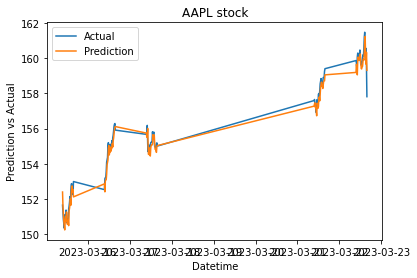

Mean squared error:  0.1928580769739731


For the stock META
The 1se lambda here would be: 0.09193248483713752


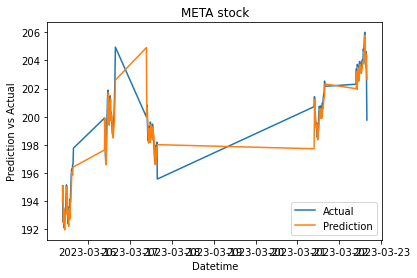

Mean squared error:  1.1112602478885591


For the stock NFLX
The 1se lambda here would be: 0.47604416708689246


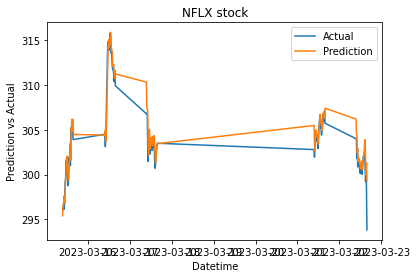

Mean squared error:  1.9096101156320135


For the stock AMZN
The 1se lambda here would be: 0.08106295403497436


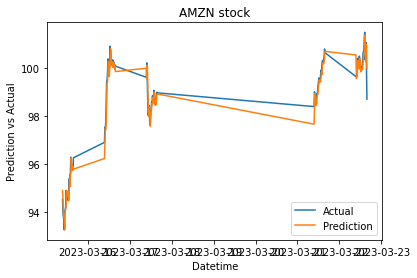

Mean squared error:  0.1573517037619444


For the stock EBAY
The 1se lambda here would be: 0.0385844568102208


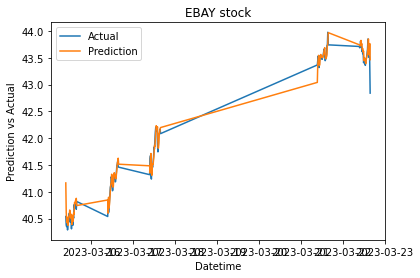

Mean squared error:  0.02238870003785035


For the stock GOOGL
The 1se lambda here would be: 0.17244434571388553


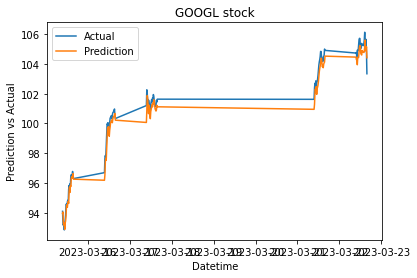

Mean squared error:  0.2945852522162678




In [77]:
for i in ["AAPL","META","NFLX","AMZN","EBAY","GOOGL"]:
    print(f"For the stock {i}")
    
    train_data = df_model_data[df_model_data['stock']==i].dropna().copy()
    test_data = df_test_data[df_test_data['stock']==i].dropna().copy()
    
    x_columns=[ 'Close_lag1', 'Open_lag1', 'High_lag1', 'Low_lag1', 'Volume_lag1',
   'Close_lag2', 'Open_lag2', 'High_lag2', 'Low_lag2', 'Volume_lag2',
   'Close_lag3', 'Open_lag3', 'High_lag3', 'Low_lag3', 'Volume_lag3',
   'daily_open', 'daily_high', 'daily_low', 'daily_close', 'daily_volume',
   'time_period']
    y_columns=['Close']

    x_train=train_data[x_columns]
    y_train=train_data[y_columns]

    #Testing data
    x_test=test_data[x_columns]
    y_test=test_data[y_columns]
    
    scaler=StandardScaler()
    x_scaled_train = scaler.fit_transform(x_train.values)
    x_scaled_test = scaler.transform(x_test.values)

    tscv =TimeSeriesSplit(gap=1, max_train_size=None, n_splits=10, test_size=None)
    lassocv = LassoCV(cv=tscv)
    lassocv.fit(x_scaled_train,np.ravel(y_train))
    optimal_alpha = lassocv.alpha_

    se = lassocv.mse_path_.std(axis=1)
    mse_mean = lassocv.mse_path_.mean(axis=1)
    idx = np.where(mse_mean <= mse_mean.min() + se[np.argmin(mse_mean)] )[0][0]
    lambda_1se = lassocv.alphas_[idx]
    print("The 1se lambda here would be: {}".format(lambda_1se))


    lasso_model = Lasso(alpha=lambda_1se)
    lasso_model.fit(x_scaled_train, np.ravel(y_train))

    # Make predictions on new data
    y_pred = lasso_model.predict(x_scaled_test)

    # Calculate mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred)
    fig, ax = plt.subplots()
    ax.plot(test_data['Datetime'], y_test['Close'], label='Actual')
    ax.plot(test_data['Datetime'], y_pred, label='Prediction')
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Prediction vs Actual')
    ax.legend()
    ax.set_title("{} stock".format(i))
    plt.show()
    
    print("Mean squared error: ", mse)
    print("\n")   